In [1]:
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from LabelAlis import LabelAlis
from scipy.stats import spearmanr

Coverage_Of_PfamChoppedStruct = 0
Coverage_Of_PfamOnQueryPosThresh = 0.25
FalsePositiveThreshold = 0.25

# Checking the number of predicted domains

In [2]:
files = ["../greedy_hits/aln_Tb_pf_fscut.tsv", "../greedy_hits/aln_Tb_pf_pdbcut.tsv",
        "../greedy_hits/aln_Tb_pf_fscut_bits__alnlen.tsv", "../greedy_hits/aln_Tb_pf_pdbcut_bits__alnlen.tsv",
        "../greedy_hits/aln_Tb_pf_seq_gr.tsv"]

In [3]:
for file in files:
    print(os.path.basename(file))
    df = pd.read_csv(file, sep="\t")
    if file.endswith("cut.tsv"):
        print(df[df["bits"]>=152].shape[0])
    elif file.endswith("alnlen.tsv"):
        print(df[df["bits__alnlen"]>=0.86].shape[0])
    else:
        print(df.shape[0])

aln_Tb_pf_fscut.tsv
6453
aln_Tb_pf_pdbcut.tsv
6095
aln_Tb_pf_fscut_bits__alnlen.tsv
6116
aln_Tb_pf_pdbcut_bits__alnlen.tsv
5623
aln_Tb_pf_seq_gr.tsv
5327


In [4]:
def SplitTargetSeedInfo(PdSeries):
    AlnPfDf = PdSeries.str.split("_", expand=True)
    AlnPfDf.columns = ["targetprot", "targetprotstart","targetprotend","predpf"]
    AlnPfDf["targetprotstart"] = AlnPfDf["targetprotstart"].astype(int)
    AlnPfDf["targetprotend"] = AlnPfDf["targetprotend"].astype(int)
    return AlnPfDf

In [5]:
def ExpandSeedAnns(AlnPfDf, pfClans):
    AlnPfDf = pd.concat([AlnPfDf, SplitTargetSeedInfo(AlnPfDf['target']) ], axis=1) 
    return AlnPfDf

In [6]:
def filter_bits(df, bits):
    return df[df["bits"]>= bits]
def filter_bits_alnlen(df, bits_alnlen):
    return df[df["bits__alnlen"]>=bits_alnlen]

In [7]:
def Labeler(inputfile, clanassociation, pf, instance_database, cols2merge = ["qstart", "qend"], filt = None ):
    df_raw = pd.read_csv(inputfile, sep="\t")
    if filt!=None:
        df = filt(df_raw)
    else:
        df = df_raw
    if instance_database:
        df = ExpandSeedAnns(df, clanassociation)
    processed_df = df.merge(clanassociation, left_on = "predpf", right_on = "pf",how="left").drop("pf", axis=1).rename(columns={"clan":"predclan"})
    Labeled_my= LabelAlis(processed_df, pf, clanassociation, ["qstart", "qend"], how2merge="right")
    prefix = pf.columns[1]
    Labeled_my = Labeled_my[(Labeled_my["isseed"]!=1 )] #|(Labeled_my["equalto"+ prefix + "preds"]==-1 )] ####NOTE: I am discarding Seed annotations for this plot
    label = pf.columns[1]
    label_dict = {0: "FP", 1: "TP", -1: "FN"}
    Labeled_my['labelcol_str']= Labeled_my["equalto{}preds".format(label)].map(label_dict)
    #Labeled_my = Labeled_my[Labeled_my["bits"]>=152]
    return Labeled_my

In [8]:
def OneHotEncodingLabel(df):
    df['is_TP'] = (df['labelcol_str'] == 'TP').astype(int)
    df['is_FP'] = (df['labelcol_str'] == 'FP').astype(int)
    df['is_FN'] = (df['labelcol_str'] == 'FN').astype(int)
    return df

In [9]:
clanassociation = pd.read_csv("../PfamClanAssociation.tsv",header=None, names = ["pf", "clan"], sep="\t" )

In [10]:
def PrecisionRecall(df, col):
    TPs = df[df[col]==1 ].shape[0]
    FPs = df[df[col]==0 ].shape[0]
    FNs = df[df[col]==-1].shape[0]
    #totalPreds = pfdf[pfdf["isseed"] !=1 ].shape[0]
    #FNs = totalPreds - TPs - FPs
    Precision = TPs/(TPs + FPs)
    Recall = TPs/(TPs + FNs + FPs)
    return Precision, Recall

In [11]:
def PlotDistributionOfLablesForAColumns(AlnDF,col4dist, label4plot, log_scale=False, legen2loc = "upper left"):
#    label_dict = {0: "FP", 1: "TP", -1: "FN"}
#    xlab_dict = {""}
# Create a new column 'labelcol_str' in the DataFrame
#    AlnDF['labelcol_str'] = AlnDF[labelcol].map(label_dict)
    plt.figure(figsize=(10, 6), dpi=150)
    ax1 = sns.kdeplot(data=AlnDF, x=col4dist, hue='labelcol_str', log_scale=log_scale,shade=True,palette='colorblind')
    
    legend = ax1.legend_
    legend.set_title(None)
    for text in legend.get_texts():
        text.set_fontsize(15)
    ax1.set_xlabel(label4plot, fontsize=15)
    ax1.set_ylabel("Density", fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)
  

# Calculating rolling Precision and Recall
    
    window_size = 200  # Change this value as needed

# Sort the DataFrame by length
    AlnDF2 = AlnDF.sort_values(by=col4dist)

# Calculate the rolling sums of TP, FP and FN
    AlnDF2['TP_sum'] = AlnDF2['is_TP'].rolling(window=window_size, center=True).sum() #
    AlnDF2['FP_sum'] = AlnDF2['is_FP'].rolling(window=window_size, center=True).sum() #
    AlnDF2['FN_sum'] = AlnDF2['is_FN'].rolling(window=window_size, center=True).sum() #
    
    AlnDF2['Precision'] = AlnDF2['TP_sum'] / (AlnDF2['TP_sum'] + AlnDF2['FP_sum'])
    AlnDF2['Recall'] = AlnDF2['TP_sum'] / (AlnDF2['TP_sum'] + AlnDF2['FN_sum'] + AlnDF2['FP_sum'])
    
    ax2 = ax1.twinx()
    ax2.plot(AlnDF2[col4dist], AlnDF2['Precision'], color='red', label='Precision',linewidth=1)  # Modify as needed
    if AlnDF2['is_FN'].sum()!=0:
        ax2.plot(AlnDF2[col4dist], AlnDF2['Recall'], color='blue', label='Recall',linewidth=1)  # Modify as needed
        ax2.set_ylabel('Precision/Recall', fontsize=15)
    else:
        ax2.set_ylabel('Precision', fontsize=15)
    ax2.legend(loc=legen2loc, fontsize=15)
    ax2.tick_params(axis='y', which='major', labelsize=15)
    ax2.set_ylim(0,1.05)
    #From now on it is for calculating the binned precision and recall

# Precision recall for different approaches
Here, we calculate the overall precision and recall for the hits selected through different approaches 

In [12]:
predictions = glob.glob("../greedy_hits/*.tsv")

aln_names2paths = {'FS_fscut':'../greedy_hits/aln_Tb_pf_fscut.tsv',
            'FS_fscut_normlen': '../greedy_hits/aln_Tb_pf_fscut_bits__alnlen.tsv',
            'FS_pdbcut':'../greedy_hits/aln_Tb_pf_pdbcut.tsv',
            'FS_pdbcut_normlen': '../greedy_hits/aln_Tb_pf_pdbcut_bits__alnlen.tsv',
             'MM': '../greedy_hits/aln_Tb_pf_seq_gr.tsv'
            }

pf = pd.read_csv("../PfamTb_SeedMeanlddtSize.txt",sep="\t")
pfn = pd.read_csv("../PfamNTb_SeedMeanlddtSize.txt",sep="\t")

In [13]:
filtered_labeled_data = {}

filtered_labeled_data['FS_fscut'] = (OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut'], clanassociation, pf, instance_database = True, filt=lambda x: filter_bits(x, 152))),
                                      OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut'], clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits(x, 152))))

filtered_labeled_data['FS_pdbcut']=  (OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut'], clanassociation, pf, instance_database = True, filt=lambda x: filter_bits(x, 152))),
                                       OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut'], clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits(x, 152))))
    
filtered_labeled_data['FS_fscut_normlen'] =  (OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut_normlen'], clanassociation, pf, instance_database = True, filt=lambda x: filter_bits_alnlen(x, 0.86))),
                                               OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut_normlen'], clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits_alnlen(x, 0.86))))

filtered_labeled_data['FS_pdbcut_normlen']=  (OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut_normlen'], clanassociation, pf, instance_database = True, filt=lambda x: filter_bits_alnlen(x, 0.86))),
                                               OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut_normlen'], clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits_alnlen(x, 0.86))))
   
filtered_labeled_data['MM'] = (OneHotEncodingLabel(Labeler(aln_names2paths['MM'], clanassociation, pf, instance_database = True)),
                               OneHotEncodingLabel(Labeler(aln_names2paths['MM'], clanassociation, pfn, instance_database = True)))

#labeled_data['FS_fscut'] = OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut'], clanassociation, pf, instance_database = True, bitscutoff=152))

In [14]:
for key in filtered_labeled_data:
    precision_recall_pf = PrecisionRecall(filtered_labeled_data[key][0],"equaltopfampreds" )
    precision_recall_clan = PrecisionRecall(filtered_labeled_data[key][0],"pfamclanisidentical" )
    precision_recall_pfn = PrecisionRecall(filtered_labeled_data[key][1],"equaltopfampreds" )
    precision_recall_clan_n = PrecisionRecall(filtered_labeled_data[key][1],"pfamclanisidentical" )
    all_pre_recall = list(precision_recall_pf) + list(precision_recall_clan) + list(precision_recall_pfn) + list(precision_recall_clan_n)
    all_pre_recall = [str(round(x,3)) for x in all_pre_recall]
    precision_recall = "\t".join(all_pre_recall)
    print(f"{key}\t{precision_recall}")

FS_fscut	0.879	0.697	0.987	0.783	0.776	0.49	0.955	0.603
FS_pdbcut	0.857	0.655	0.982	0.75	0.752	0.455	0.953	0.576
FS_fscut_normlen	0.907	0.679	0.989	0.741	0.823	0.458	0.977	0.543
FS_pdbcut_normlen	0.896	0.637	0.987	0.702	0.815	0.423	0.976	0.507
MM	0.953	0.68	0.992	0.708	0.897	0.407	0.988	0.448


The following cells are for calculating the precision and recall without considering any threshold:

In [15]:
nonfiltered_labeled_data = {}

nonfiltered_labeled_data['FS_fscut'] = (OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut'], clanassociation, pf, instance_database = True)),
                                      OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut'], clanassociation, pfn, instance_database = True)))

nonfiltered_labeled_data['FS_pdbcut']=  (OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut'], clanassociation, pf, instance_database = True)),
                                       OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut'], clanassociation, pfn, instance_database = True)))
    
nonfiltered_labeled_data['FS_fscut_normlen'] =  (OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut_normlen'], clanassociation, pf, instance_database = True)),
                                               OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut_normlen'], clanassociation, pfn, instance_database = True)))

nonfiltered_labeled_data['FS_pdbcut_normlen']=  (OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut_normlen'], clanassociation, pf, instance_database = True)),
                                               OneHotEncodingLabel(Labeler(aln_names2paths['FS_pdbcut_normlen'], clanassociation, pfn, instance_database = True)))
   
nonfiltered_labeled_data['MM'] = (OneHotEncodingLabel(Labeler(aln_names2paths['MM'], clanassociation, pf, instance_database = True)),
                               OneHotEncodingLabel(Labeler(aln_names2paths['MM'], clanassociation, pfn, instance_database = True)))

#labeled_data['FS_fscut'] = OneHotEncodingLabel(Labeler(aln_names2paths['FS_fscut'], clanassociation, pf, instance_database = True, bitscutoff=152))

In [16]:
for key in nonfiltered_labeled_data:
    precision_recall_pf = PrecisionRecall(nonfiltered_labeled_data[key][0],"equaltopfampreds" )
    precision_recall_clan = PrecisionRecall(nonfiltered_labeled_data[key][0],"pfamclanisidentical" )
    precision_recall_pfn = PrecisionRecall(nonfiltered_labeled_data[key][1],"equaltopfampreds" )
    precision_recall_clan_n = PrecisionRecall(nonfiltered_labeled_data[key][1],"pfamclanisidentical" )
    all_pre_recall = list(precision_recall_pf) + list(precision_recall_clan) + list(precision_recall_pfn) + list(precision_recall_clan_n)
    all_pre_recall = [str(round(x,3)) for x in all_pre_recall]
    precision_recall = "\t".join(all_pre_recall)
    print(f"{key}\t{precision_recall}")

FS_fscut	0.859	0.704	0.974	0.799	0.74	0.503	0.928	0.63
FS_pdbcut	0.819	0.663	0.953	0.771	0.712	0.469	0.923	0.608
FS_fscut_normlen	0.836	0.705	0.947	0.799	0.726	0.499	0.915	0.629
FS_pdbcut_normlen	0.811	0.667	0.94	0.773	0.698	0.469	0.91	0.612
MM	0.953	0.68	0.992	0.708	0.897	0.407	0.988	0.448


The following cells calculates how often the hits that do not match at the clan level, belong to a clan:

In [17]:
def PercentageOfHitsHavingTheSameClan(df):
    whole = df.shape[0]
    seed_has_clan = df['predclan'].str.contains("CL")
    pf_has_clan = df['pfamclan'].str.contains("CL")
    clan_different_but_belong2Clan = df[((df["pfamclanisidentical"]==0) & (seed_has_clan)) &(pf_has_clan)]
    return clan_different_but_belong2Clan.shape[0]/whole

In [18]:
for key,dfs in filtered_labeled_data.items():
    df_pf, df_pfn = dfs
    print(PercentageOfHitsHavingTheSameClan(df_pf))
    print(PercentageOfHitsHavingTheSameClan(df_pfn))

0.004812141402924301
0.004505052964811884
0.004812141402924301
0.004505052964811884
0.004997223764575236
0.0032874710824302936
0.004441976679622432
0.0028004383294776575
0.0018508236165093468
0.00048703275295263604


In [19]:
filtered_labeled_data.keys()

dict_keys(['FS_fscut', 'FS_pdbcut', 'FS_fscut_normlen', 'FS_pdbcut_normlen', 'MM'])

In the following cells, we benchmark our predictions against reference annotations from Pfam and Pfam-N

# Pfam as the Gold Standard

In [17]:
pf = pd.read_csv("../PfamTb_SeedMeanlddtSize.txt",sep="\t")
HMMER_preds_vsPF = OneHotEncodingLabel(Labeler("../greedy_hits/HmmerGreedyHits.tsv", clanassociation, pf, instance_database = False ))
MM_preds_vsPF = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_seq_gr.tsv", clanassociation, pf, instance_database = True))

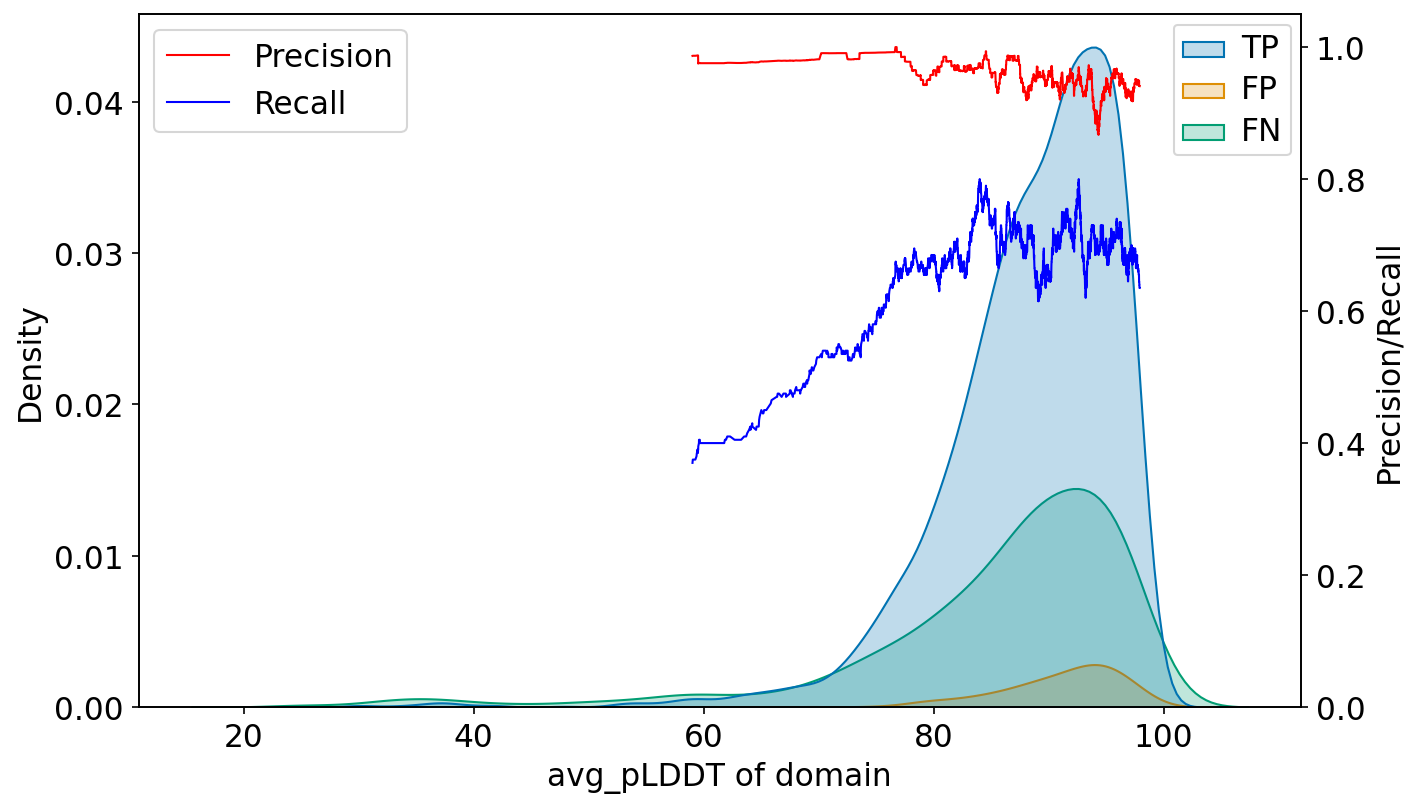

In [18]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPF,  "meanlddt", "avg_pLDDT of domain")

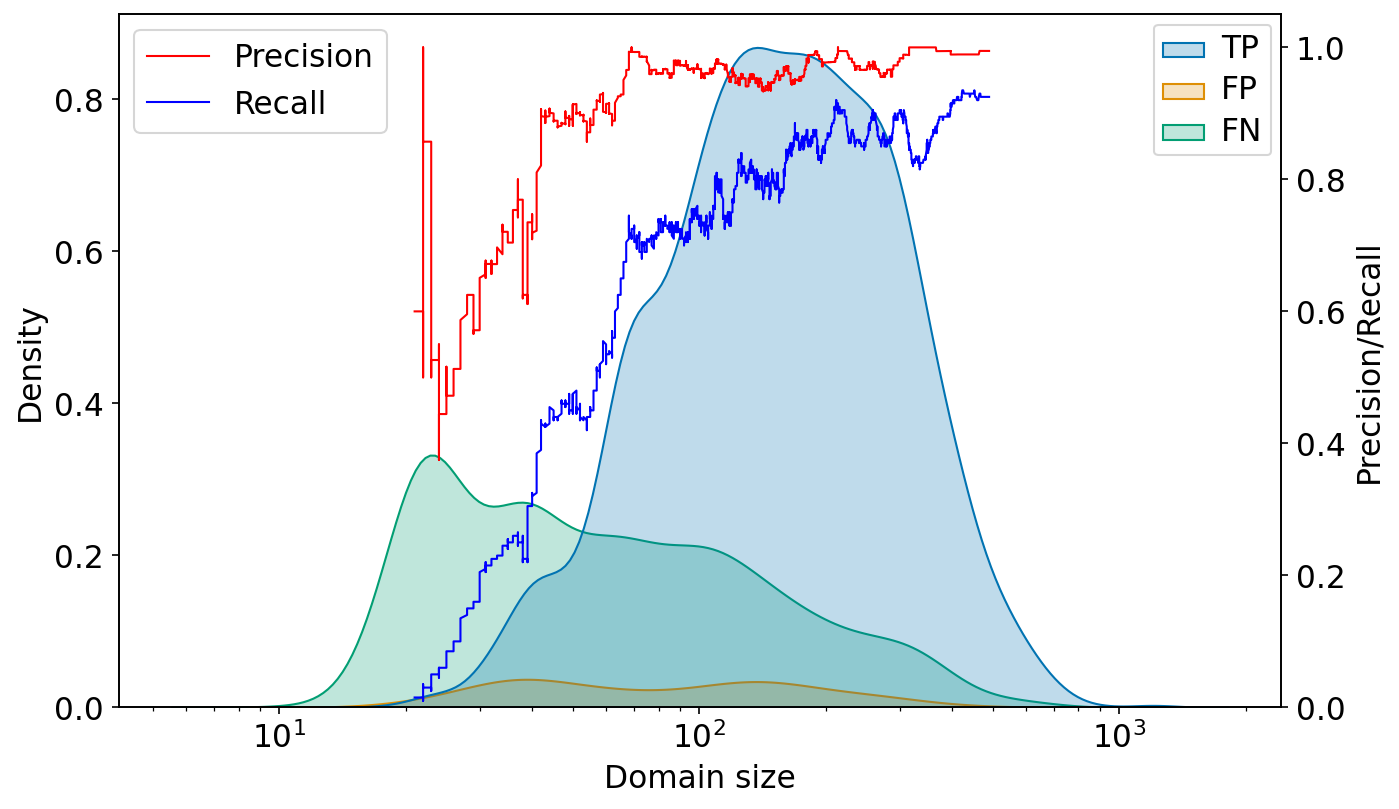

In [19]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPF, "size","Domain size", log_scale=10)

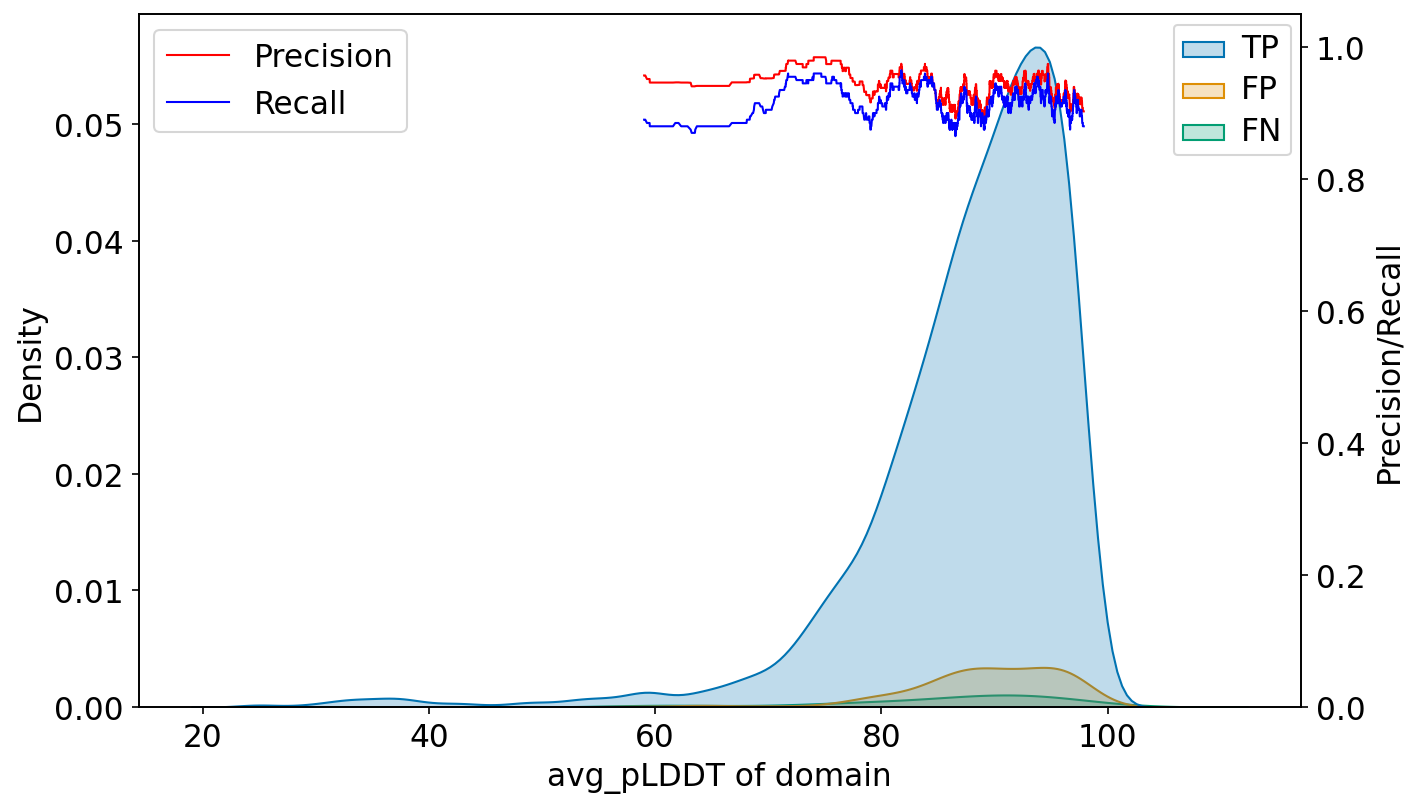

In [20]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPF,  "meanlddt", "avg_pLDDT of domain")

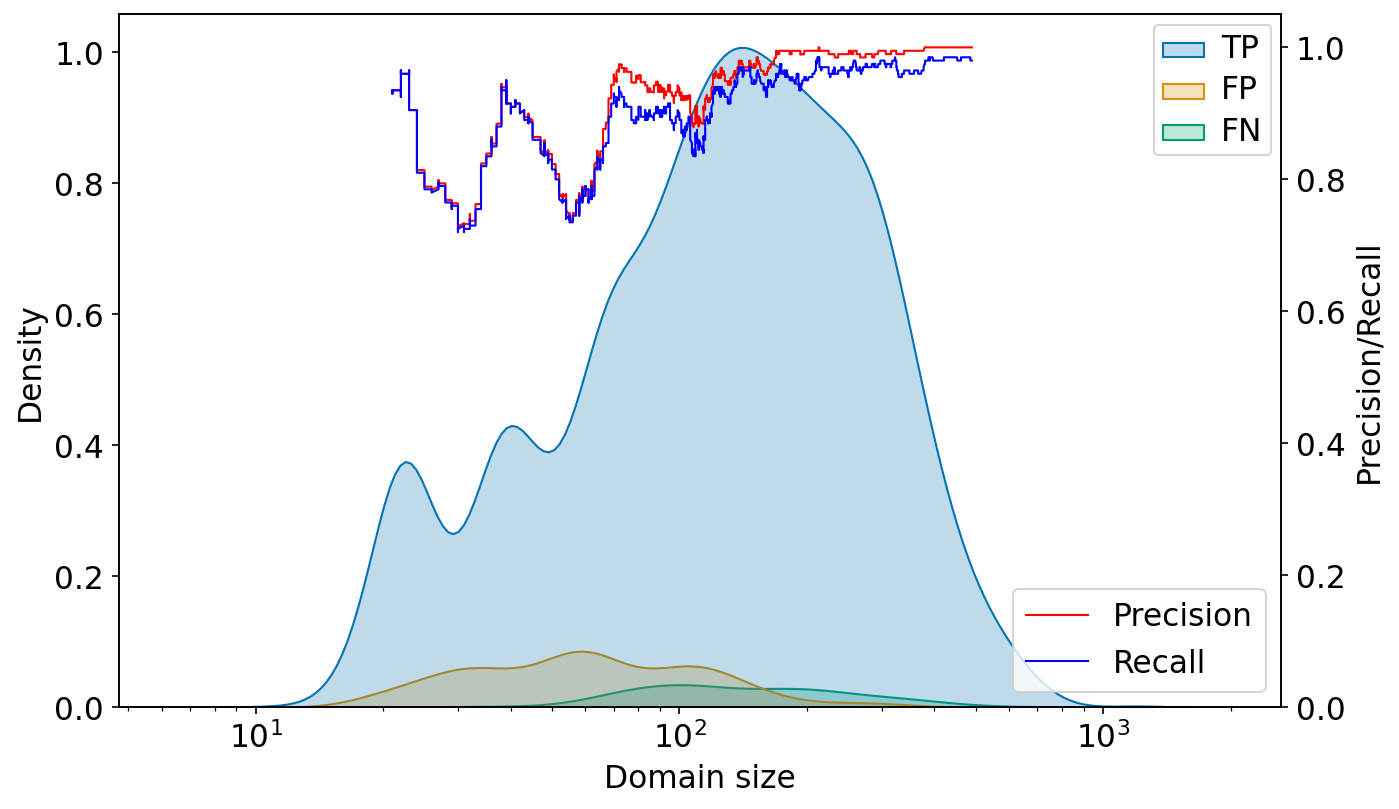

In [21]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPF, "size","Domain size", log_scale=10, legen2loc=("lower right"))

In [22]:
correlation, p_value = spearmanr(pf["size"], pf["meanlddt"])
print(correlation)
print(p_value)

-0.0758710672721816
5.275324159949638e-10


## FS_cut bits/alnlen

In [23]:
FS_preds_vsPF = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_fscut_bits__alnlen.tsv", clanassociation, pf, instance_database = True, filt = lambda x: filter_bits_alnlen(x, 0.86))) #

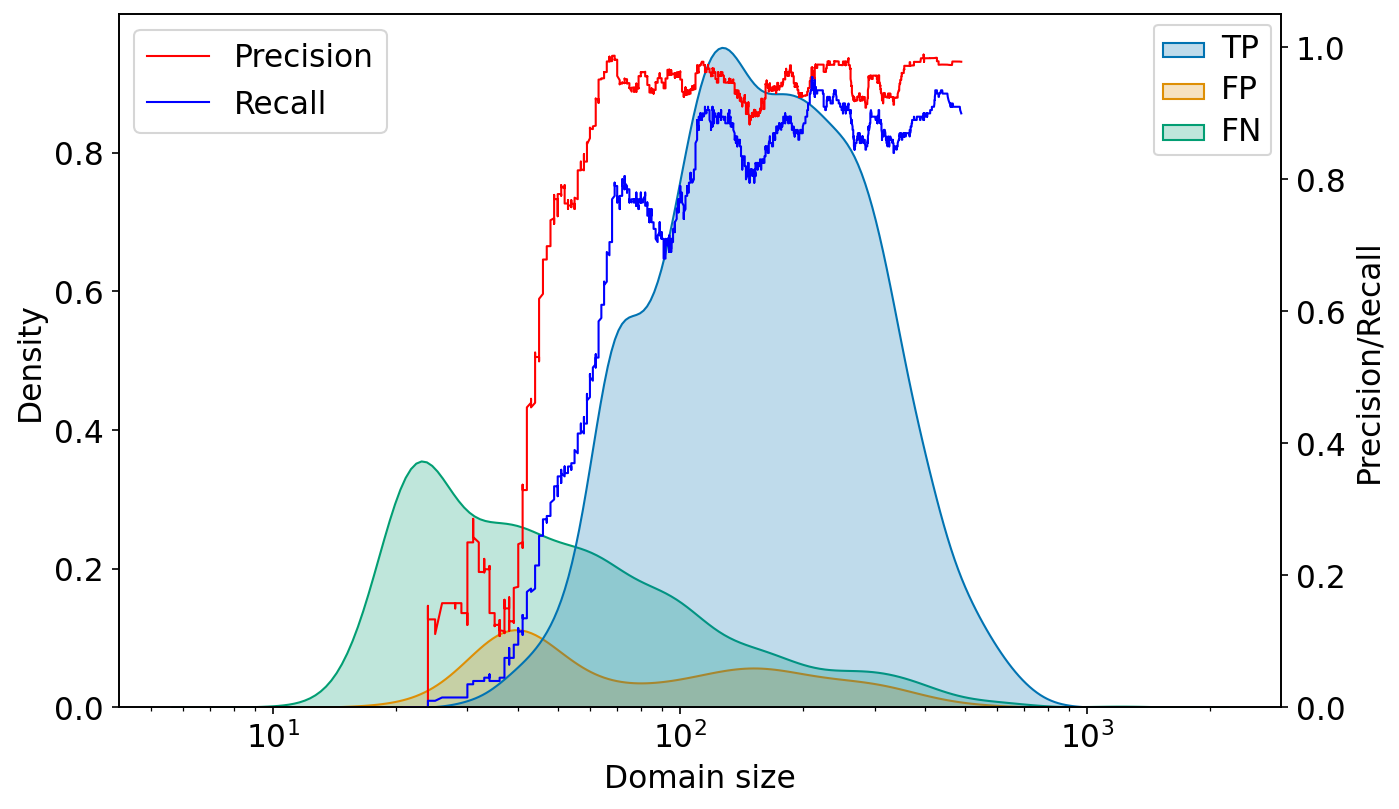

In [24]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "size", "Domain size", log_scale=10)

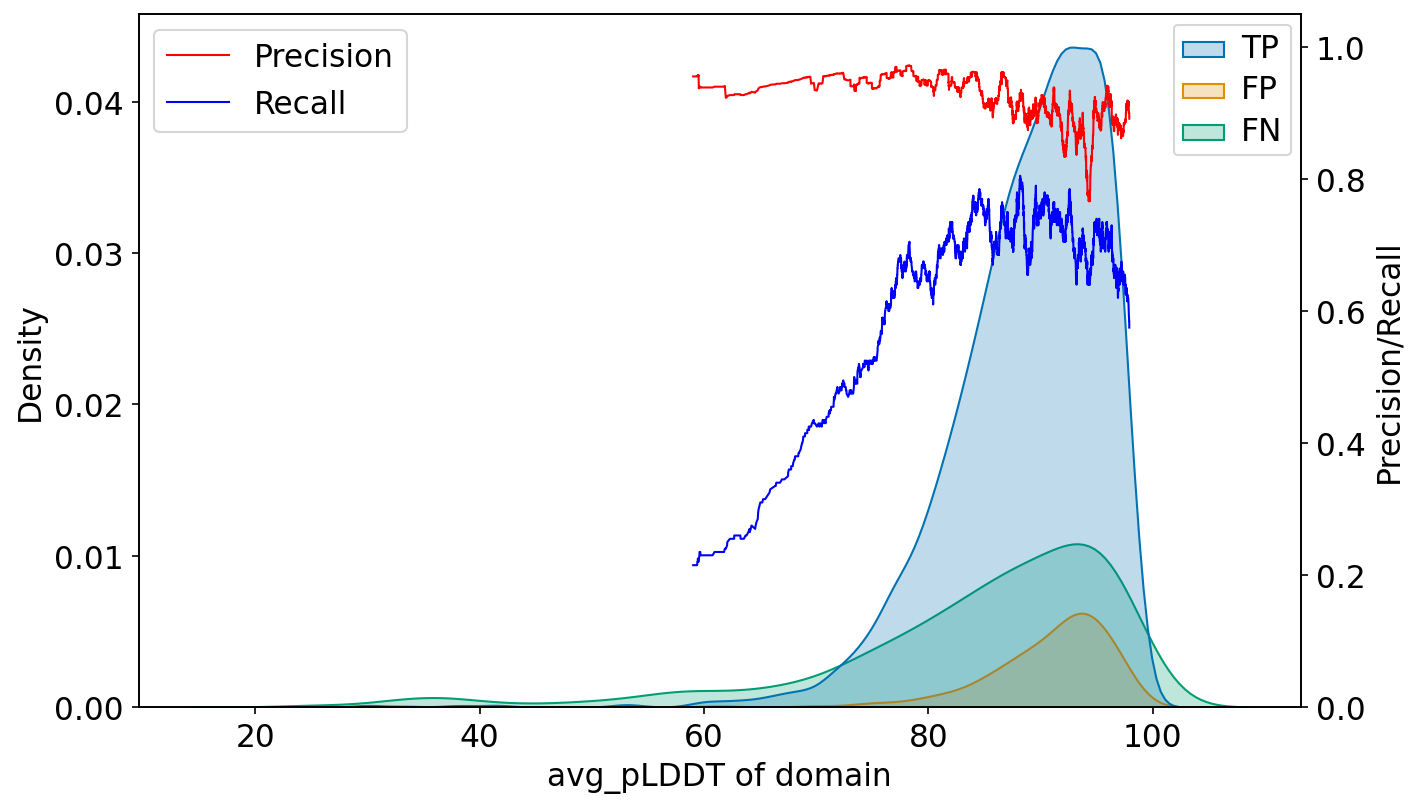

In [25]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "meanlddt", "avg_pLDDT of domain")

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-100.0, 1000.0)

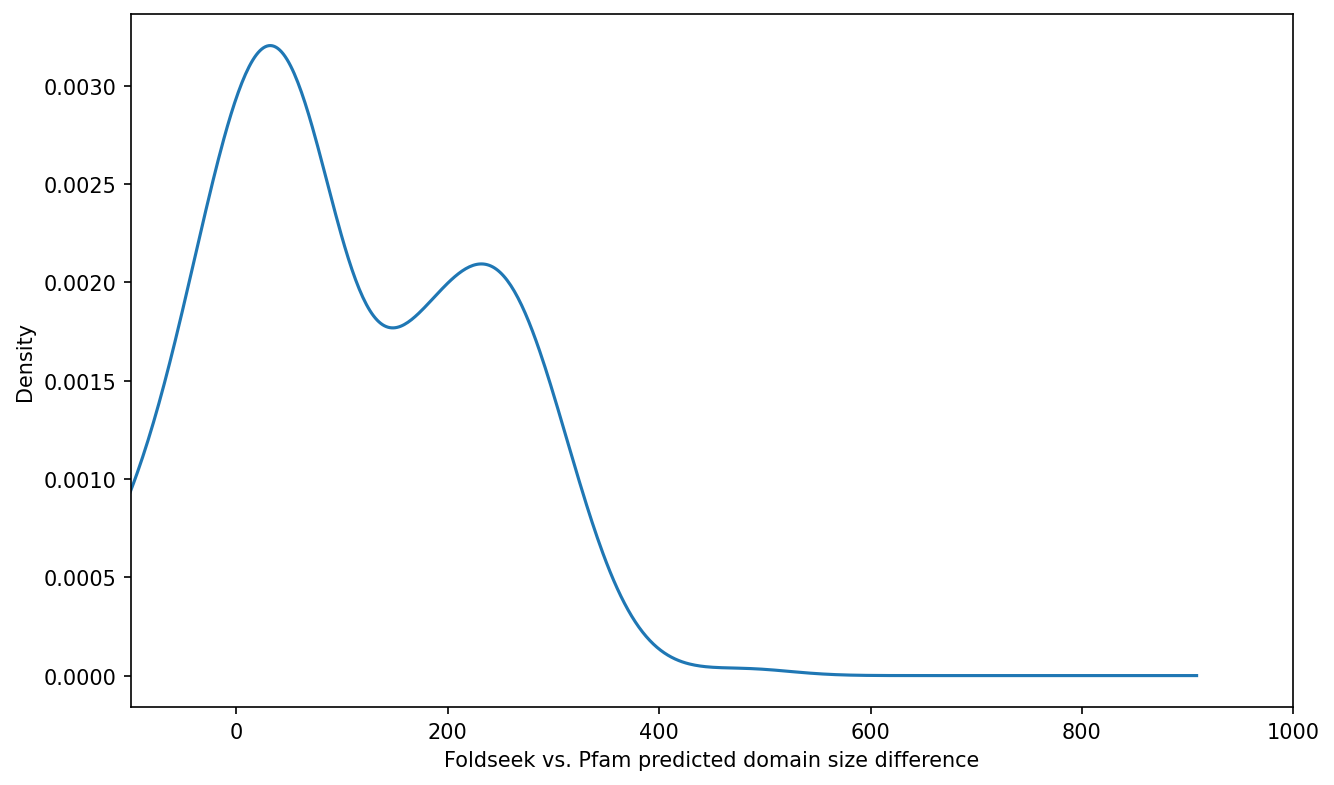

In [26]:
FPs_PF = FS_preds_vsPF[FS_preds_vsPF["labelcol_str"]=="FP"]
FPs_PF=FPs_PF[(FPs_PF["qend"] - FPs_PF["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PF["qend"] - FPs_PF["qstart"]) - (FPs_PF["pfend"] - FPs_PF["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam predicted domain size difference")
plt.xlim((-100,1000))

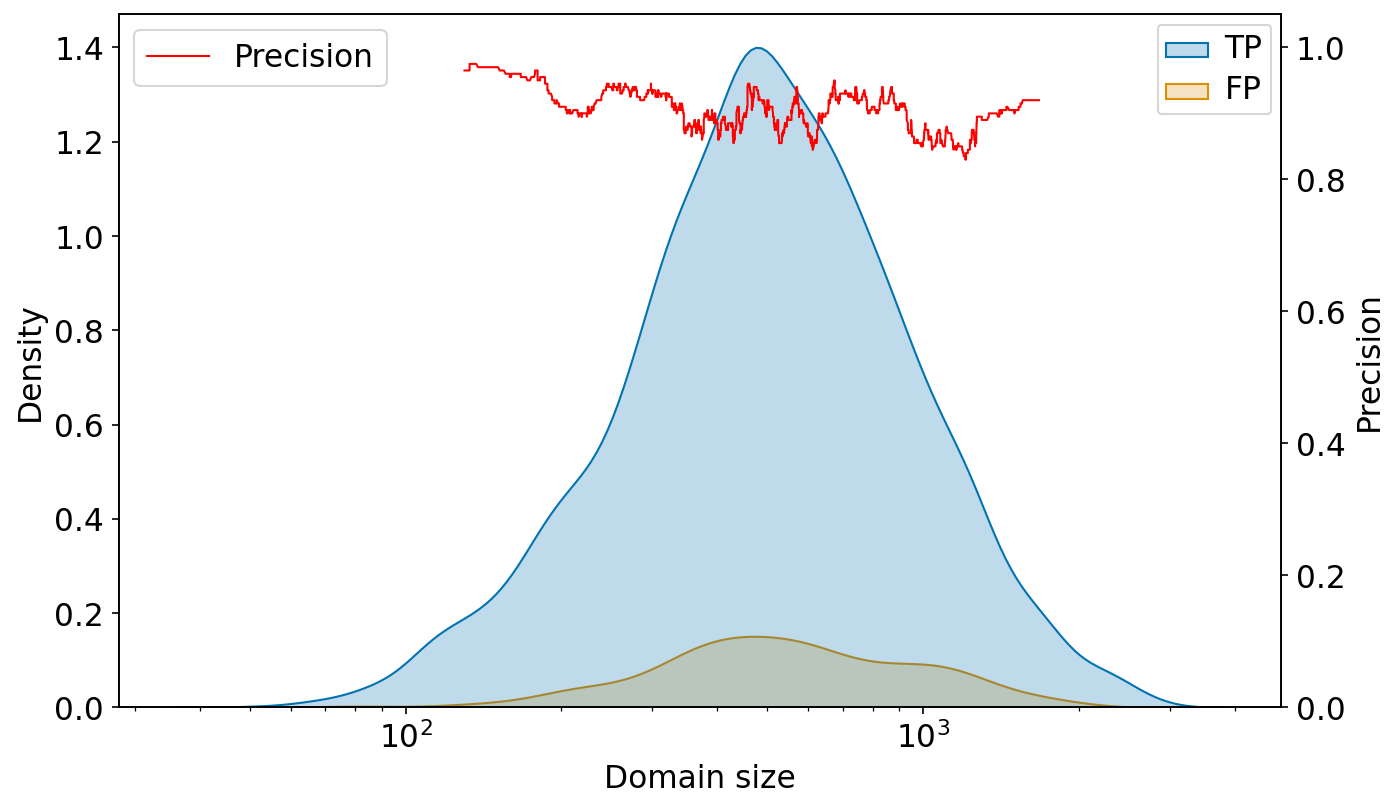

In [27]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF[FS_preds_vsPF['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)

## PDB_cut bits/alnlen

In [28]:
FS_preds_vsPF = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_pdbcut_bits__alnlen.tsv", clanassociation, pf, instance_database = True, filt = lambda x: filter_bits_alnlen(x, 0.86))) #

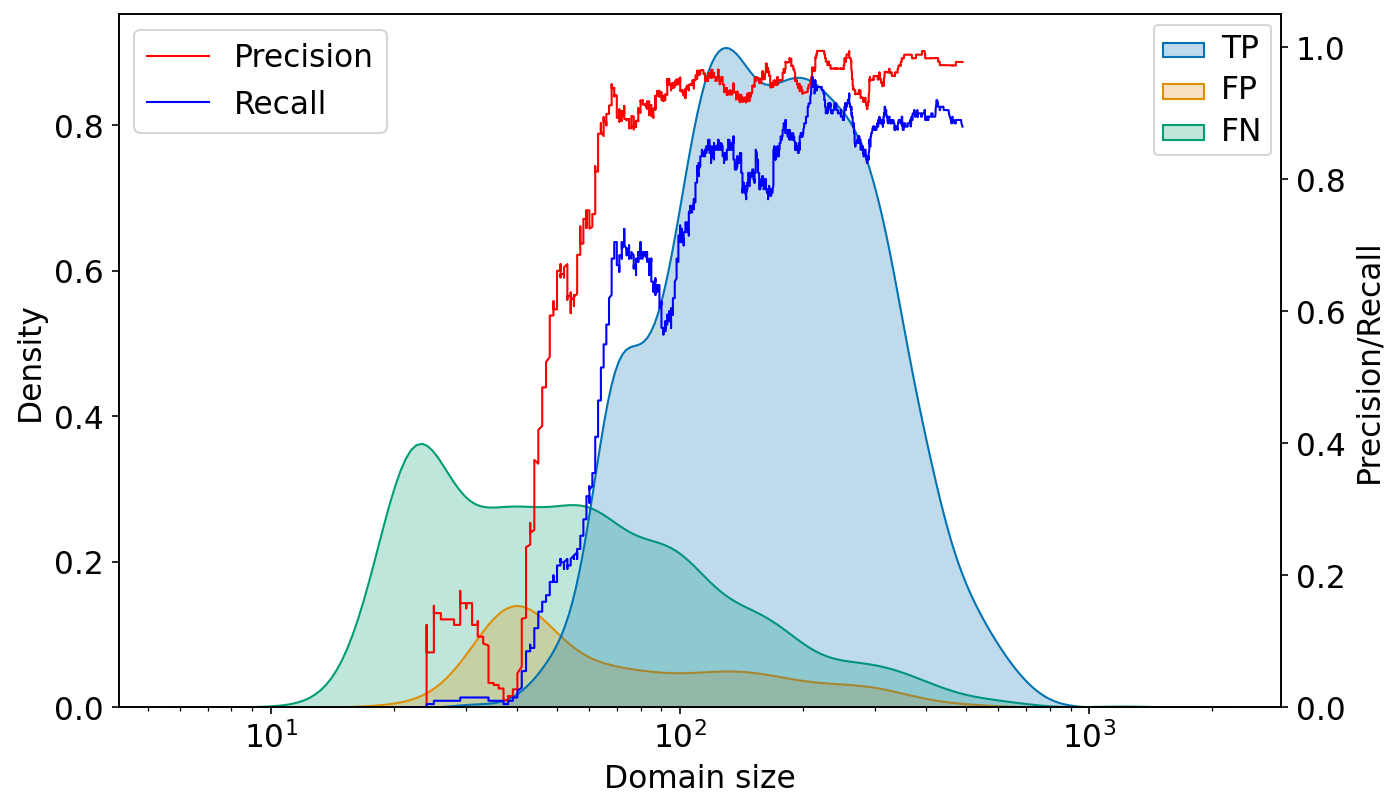

In [29]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "size", "Domain size", log_scale=10)

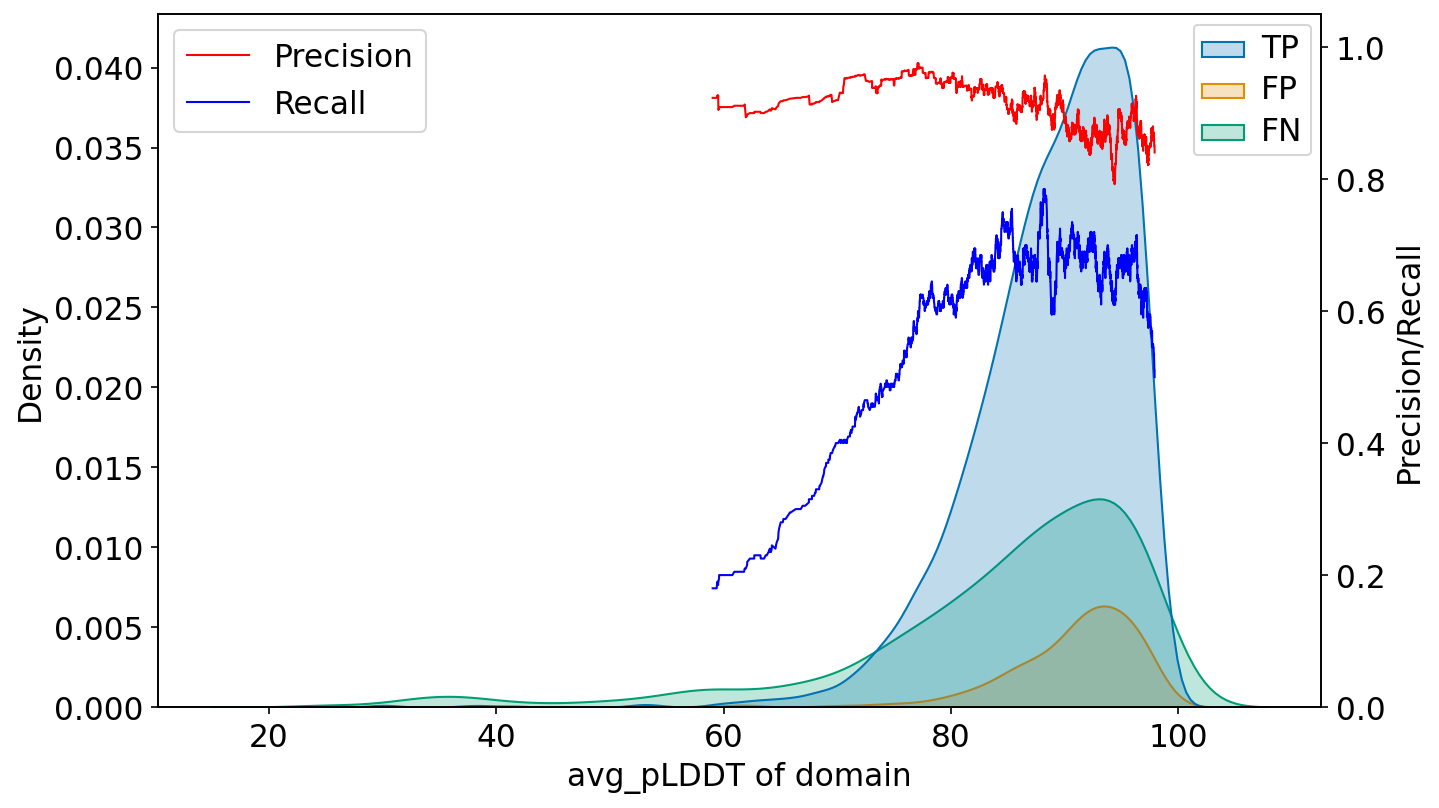

In [30]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "meanlddt", "avg_pLDDT of domain")

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-100.0, 1000.0)

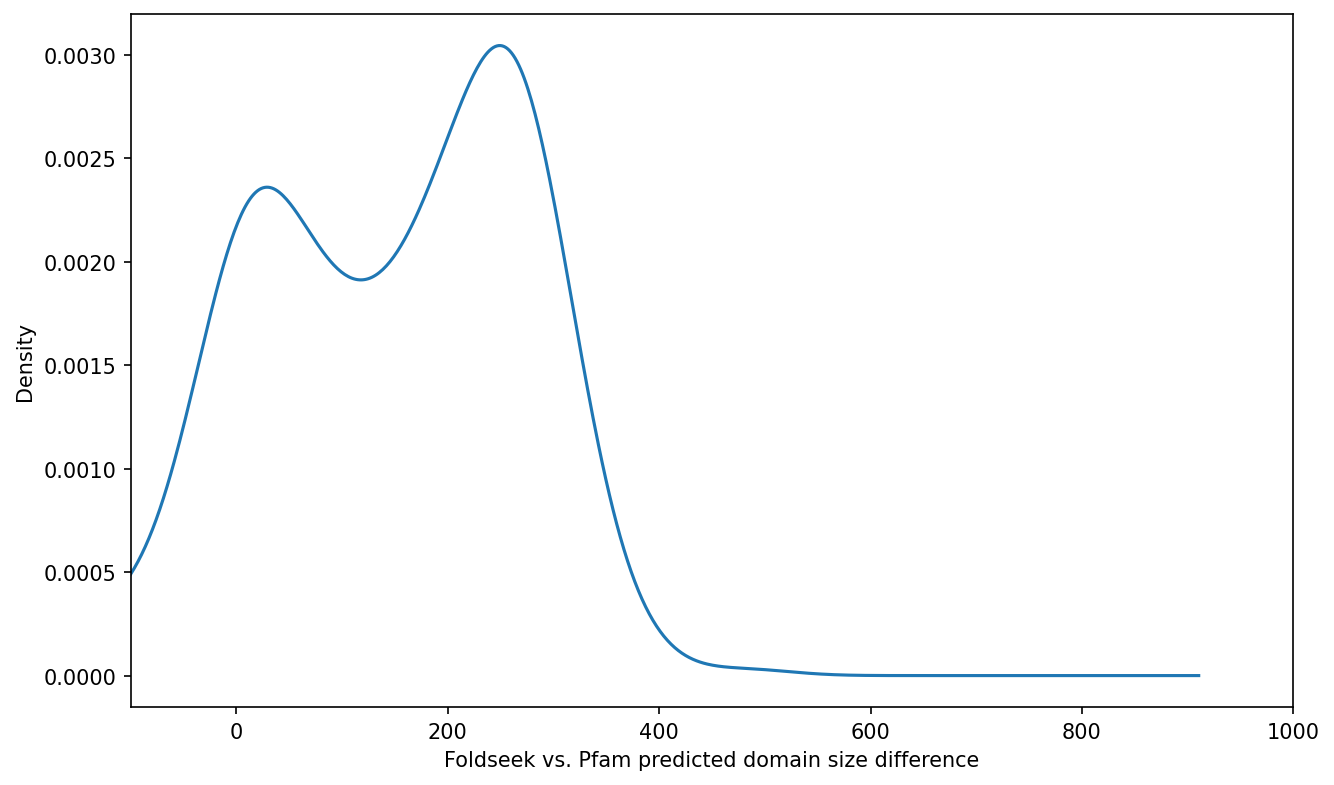

In [31]:
FPs_PF = FS_preds_vsPF[FS_preds_vsPF["labelcol_str"]=="FP"]
FPs_PF=FPs_PF[(FPs_PF["qend"] - FPs_PF["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PF["qend"] - FPs_PF["qstart"]) - (FPs_PF["pfend"] - FPs_PF["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam predicted domain size difference")
plt.xlim((-100,1000))

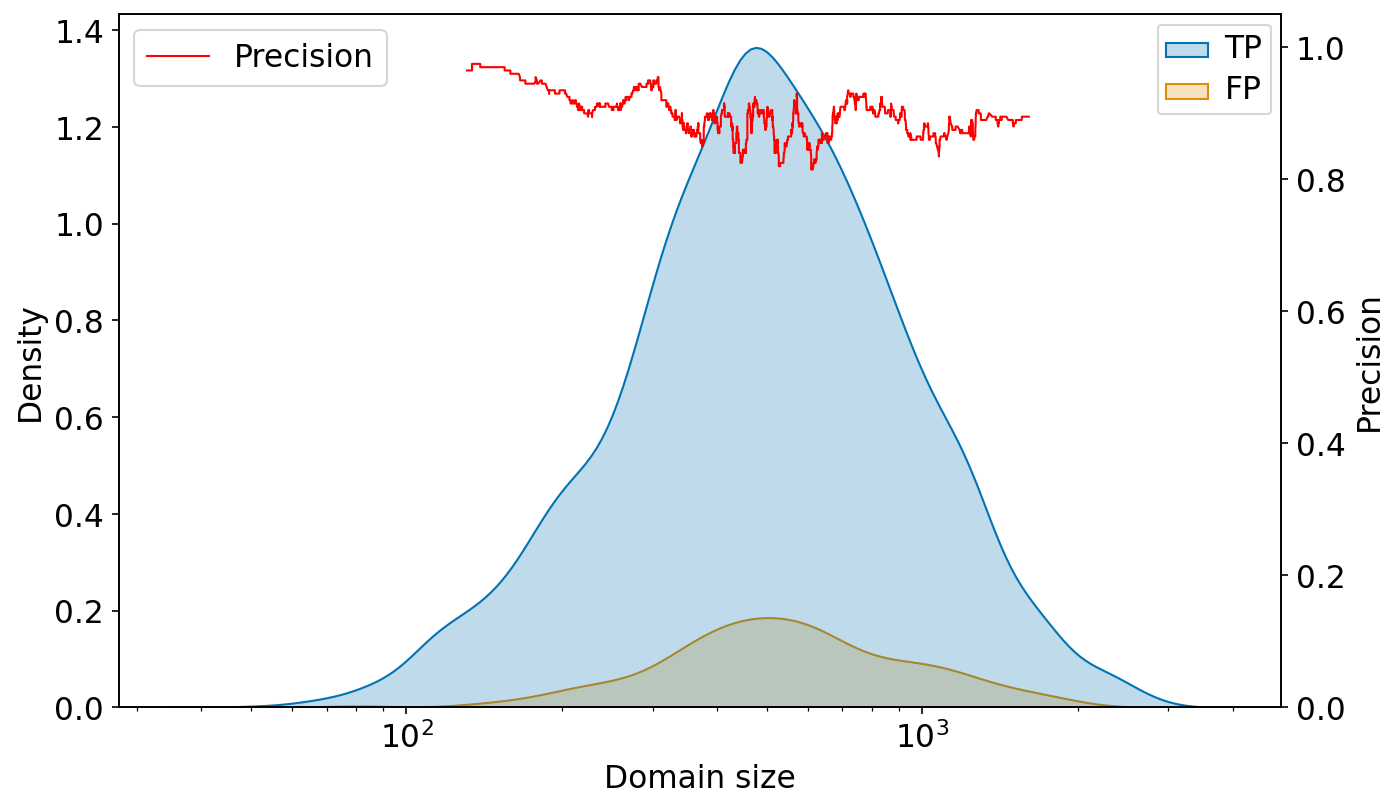

In [32]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF[FS_preds_vsPF['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)

## FS_cut bits

In [33]:
FS_preds_vsPF = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_fscut.tsv", clanassociation, pf, instance_database = True, filt = lambda x: filter_bits(x, 152))) #

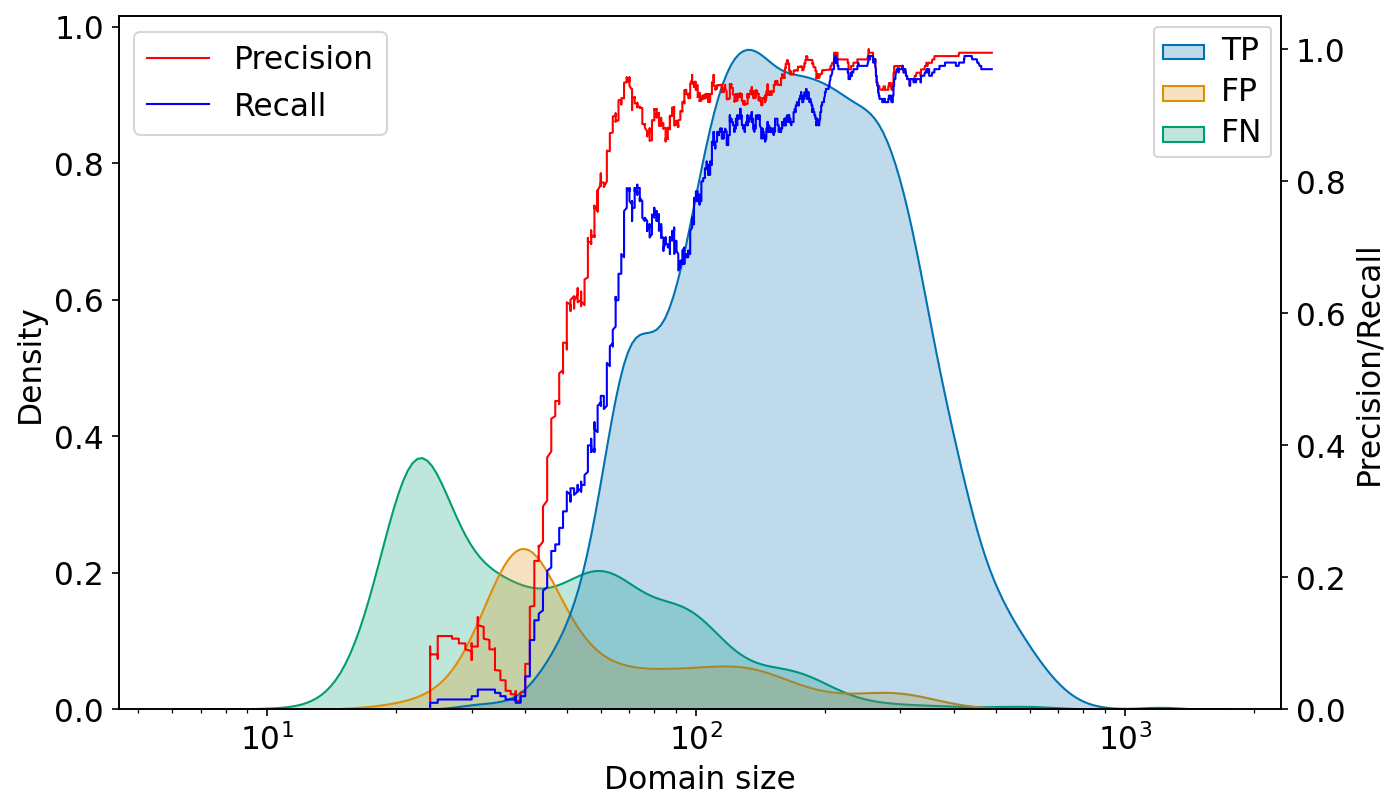

In [34]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "size", "Domain size", log_scale=10)

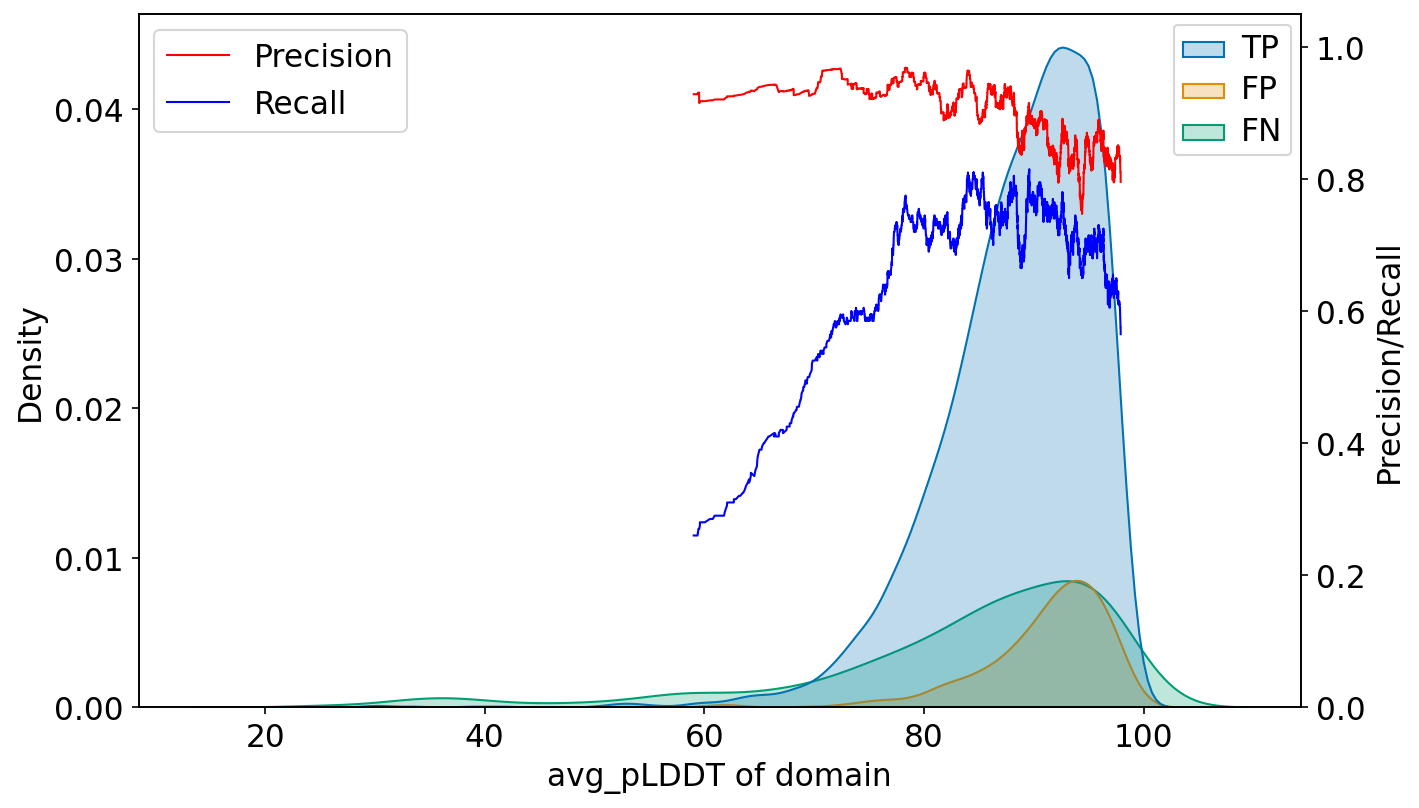

In [35]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "meanlddt", "avg_pLDDT of domain")

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-100.0, 1000.0)

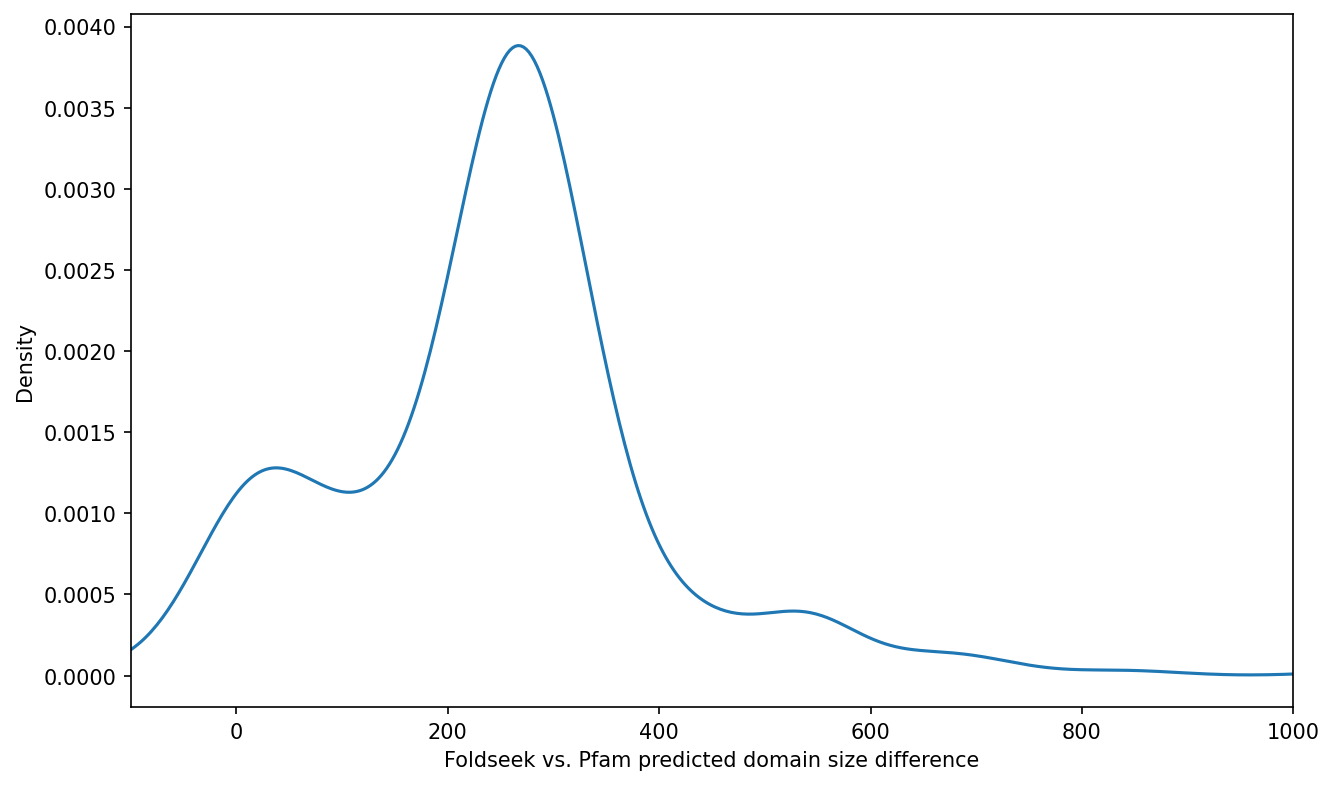

In [36]:
FPs_PF = FS_preds_vsPF[FS_preds_vsPF["labelcol_str"]=="FP"]
FPs_PF=FPs_PF[(FPs_PF["qend"] - FPs_PF["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PF["qend"] - FPs_PF["qstart"]) - (FPs_PF["pfend"] - FPs_PF["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam predicted domain size difference")
plt.xlim((-100,1000))

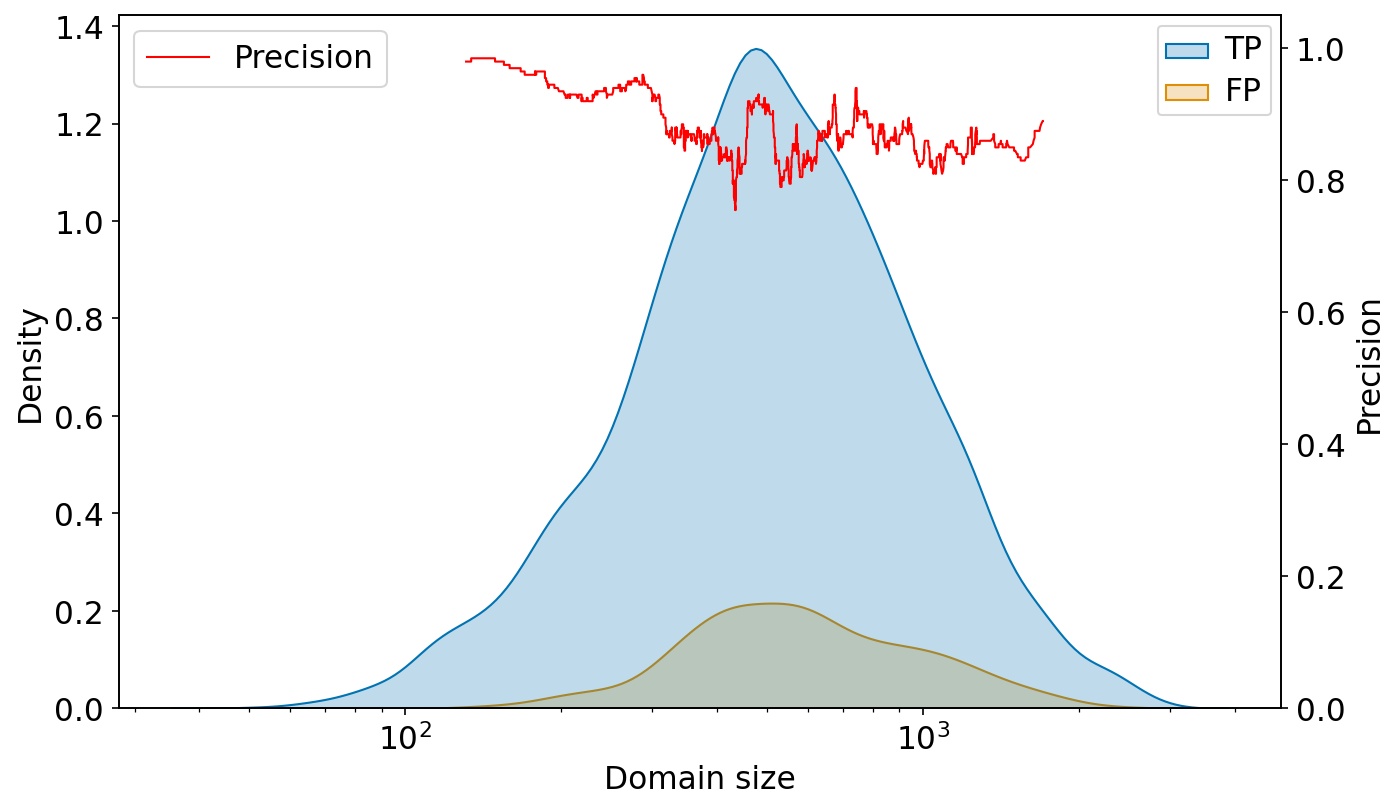

In [37]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF[FS_preds_vsPF['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)

## PDB_cut bits

In [39]:
FS_preds_vsPF = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_pdbcut.tsv", clanassociation, pf, instance_database = True, filt = lambda x: filter_bits(x, 152))) #

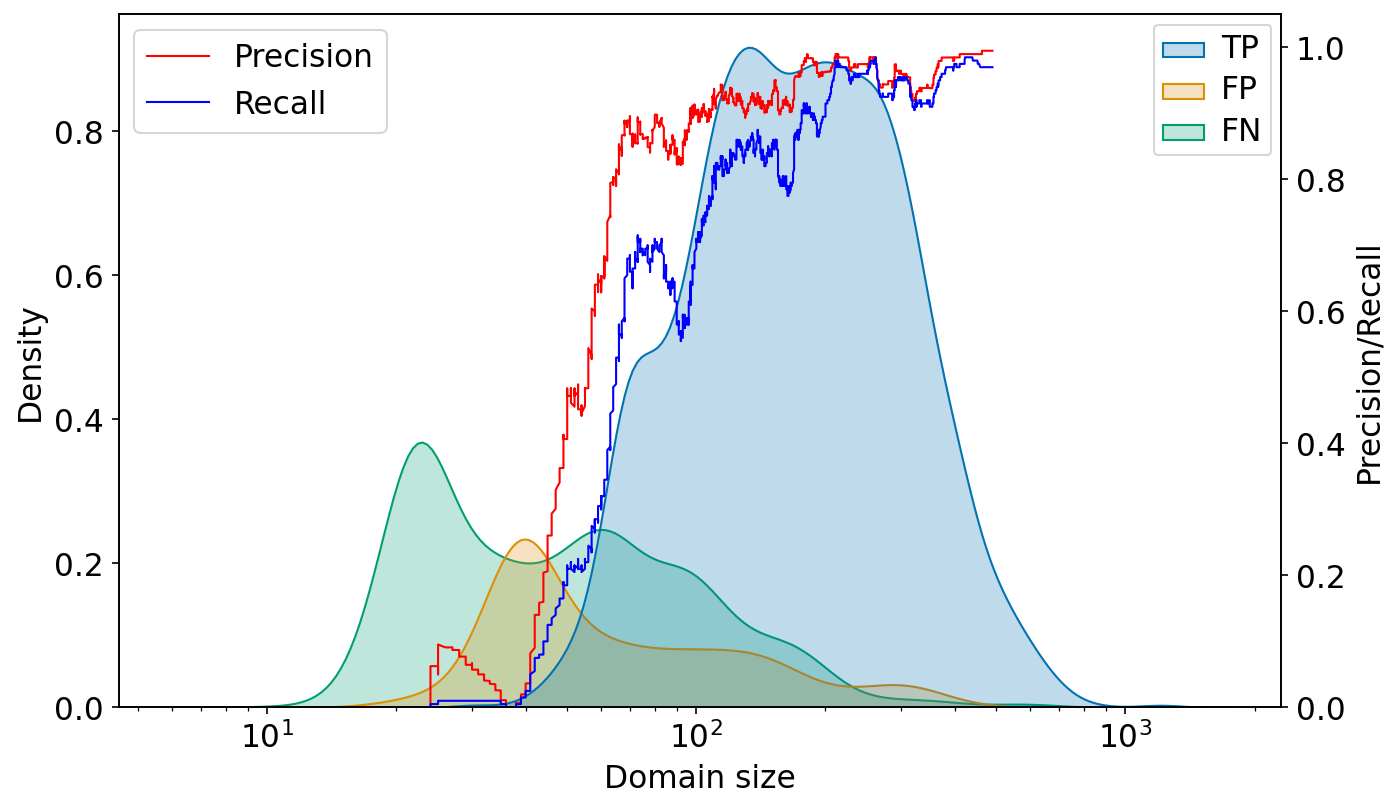

In [40]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "size", "Domain size", log_scale=10)

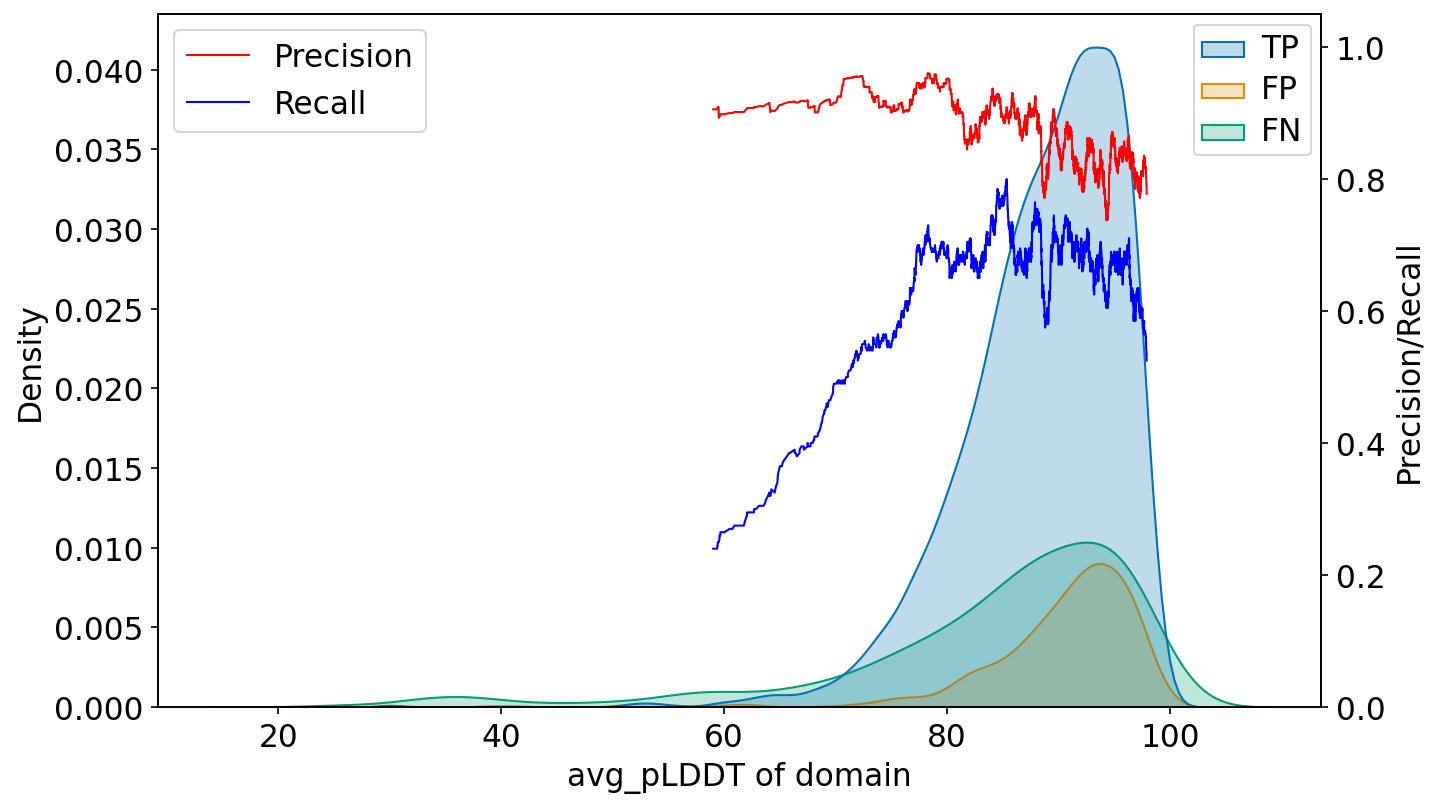

In [41]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF, "meanlddt", "avg_pLDDT of domain")

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-100.0, 1000.0)

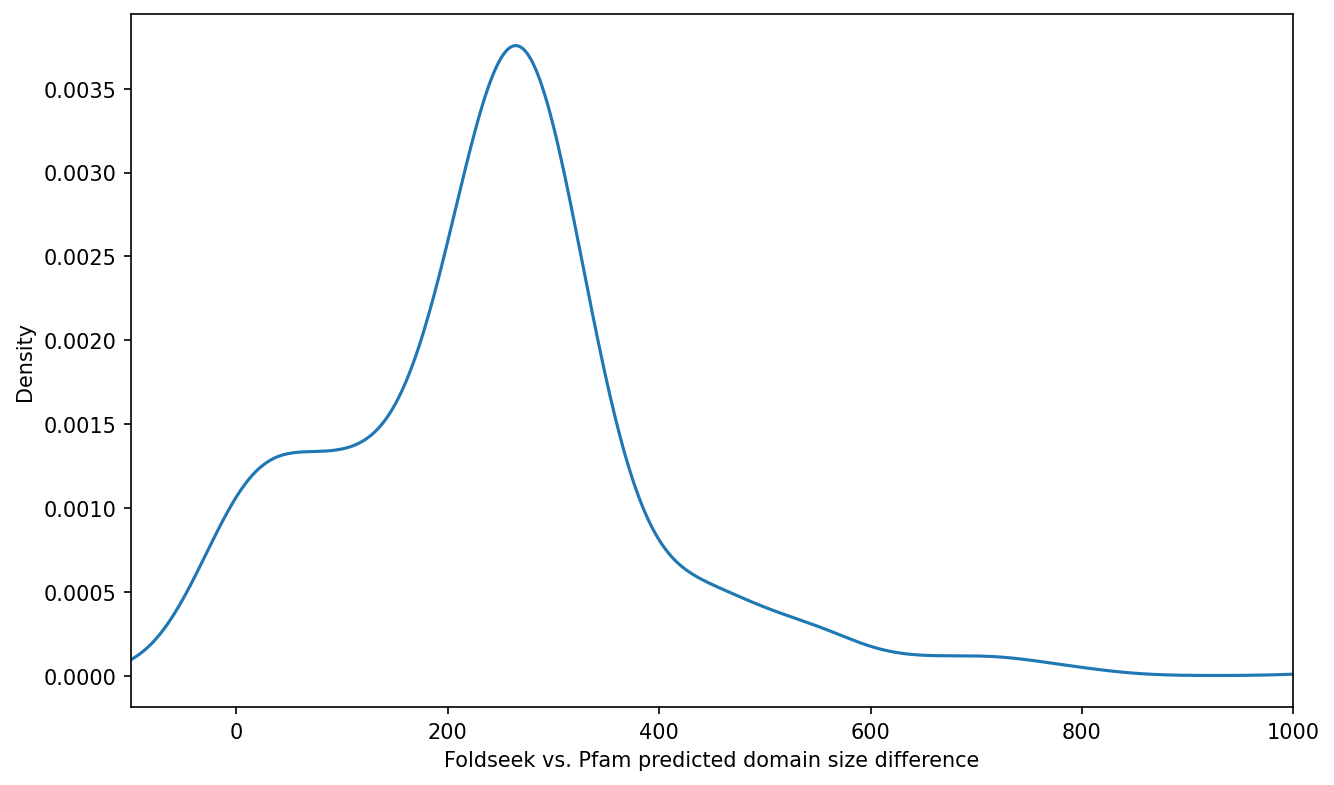

In [42]:
FPs_PF = FS_preds_vsPF[FS_preds_vsPF["labelcol_str"]=="FP"]
FPs_PF=FPs_PF[(FPs_PF["qend"] - FPs_PF["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PF["qend"] - FPs_PF["qstart"]) - (FPs_PF["pfend"] - FPs_PF["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam predicted domain size difference")
plt.xlim((-100,1000))

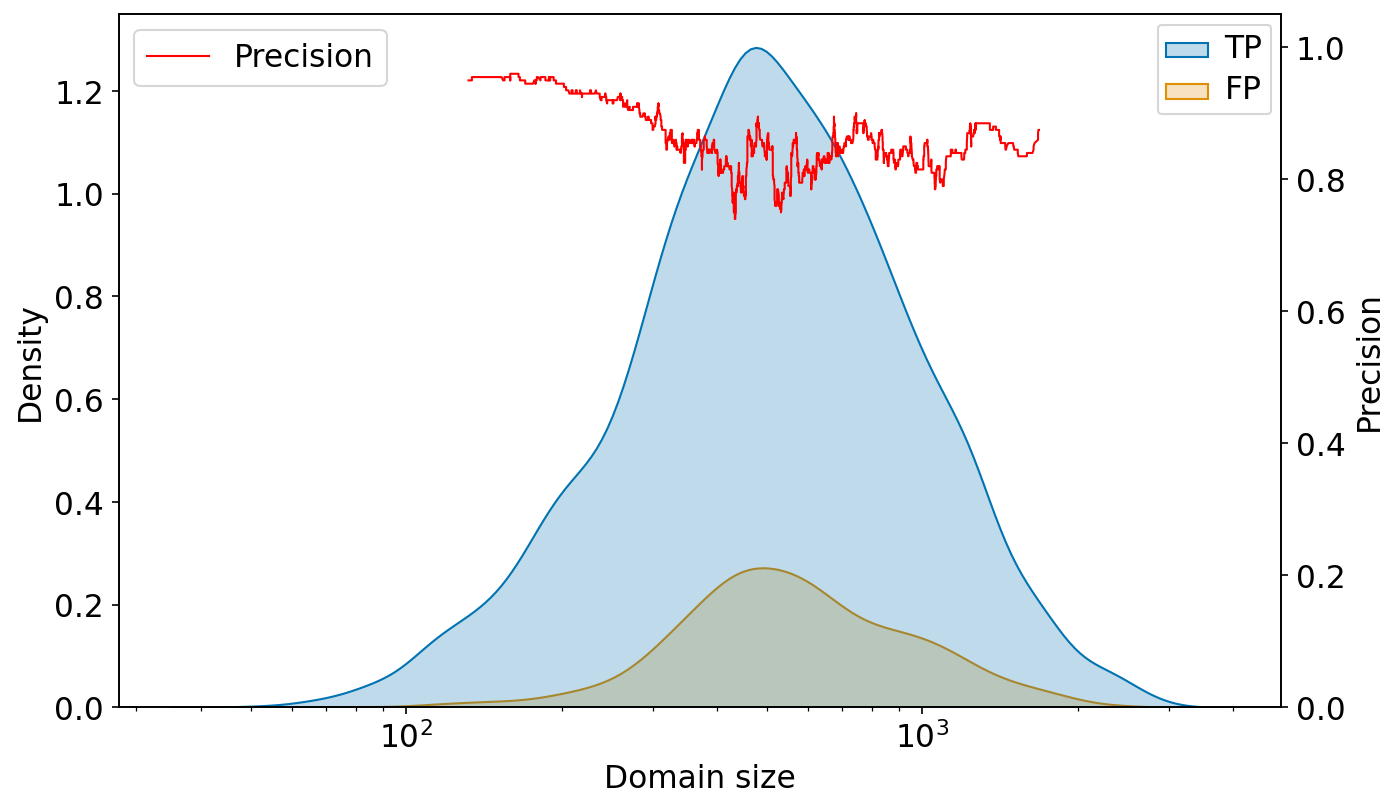

In [43]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPF[FS_preds_vsPF['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)

# Pfam-N as the Gold Standard

In [81]:
pfn = pd.read_csv("../PfamNTb_SeedMeanlddtSize.txt",sep="\t")
MM_preds_vsPFn = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_seq_gr.tsv", clanassociation, pfn, instance_database = True))
HMMER_preds_vsPFn = OneHotEncodingLabel(Labeler("../greedy_hits/HmmerGreedyHits.tsv", clanassociation, pfn, instance_database = False))
#HMMER_preds_vsPF = OneHotEncodingLabel(Labeler("../HmmerGreedyHits.tsv", clanassociation, pf, instance_database = False ))

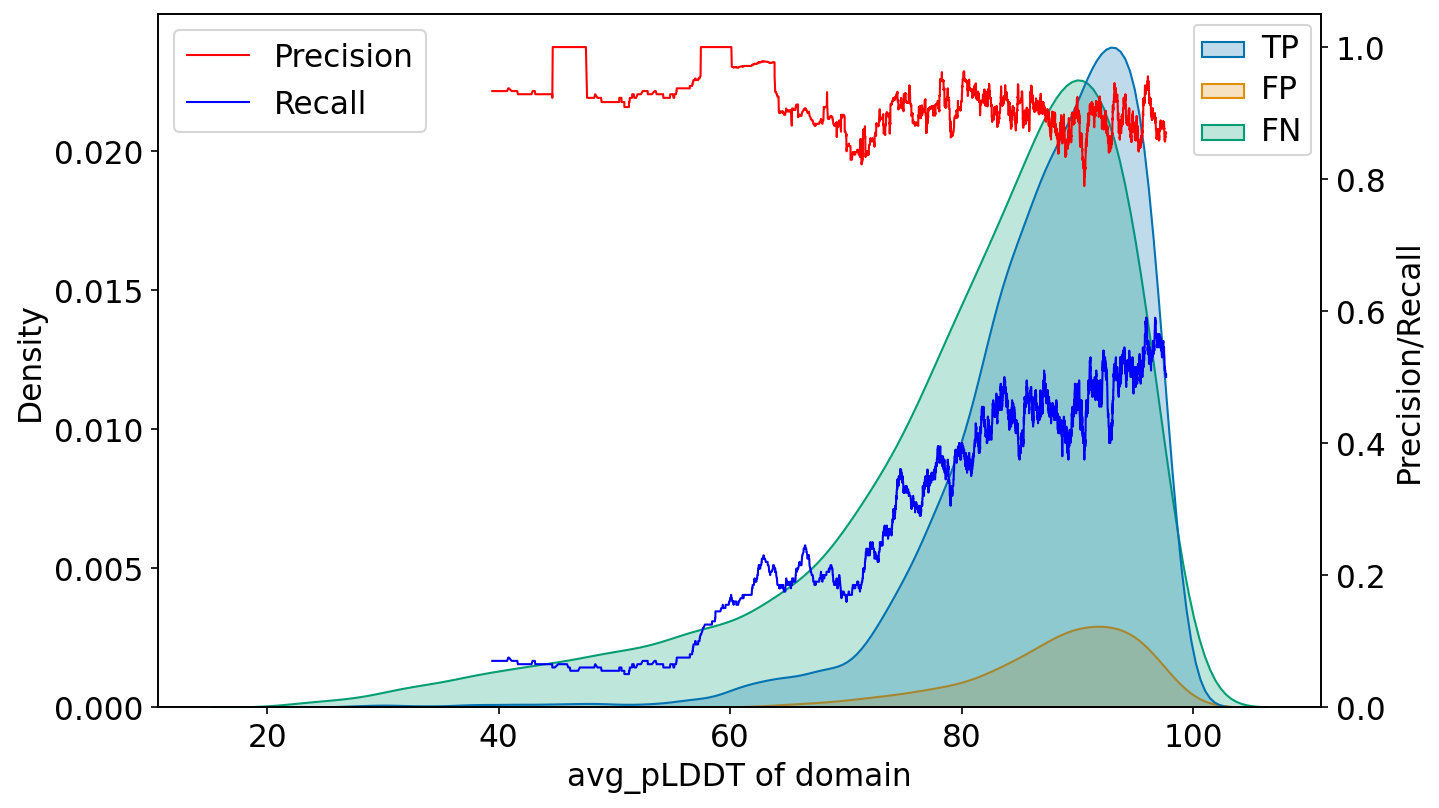

In [45]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

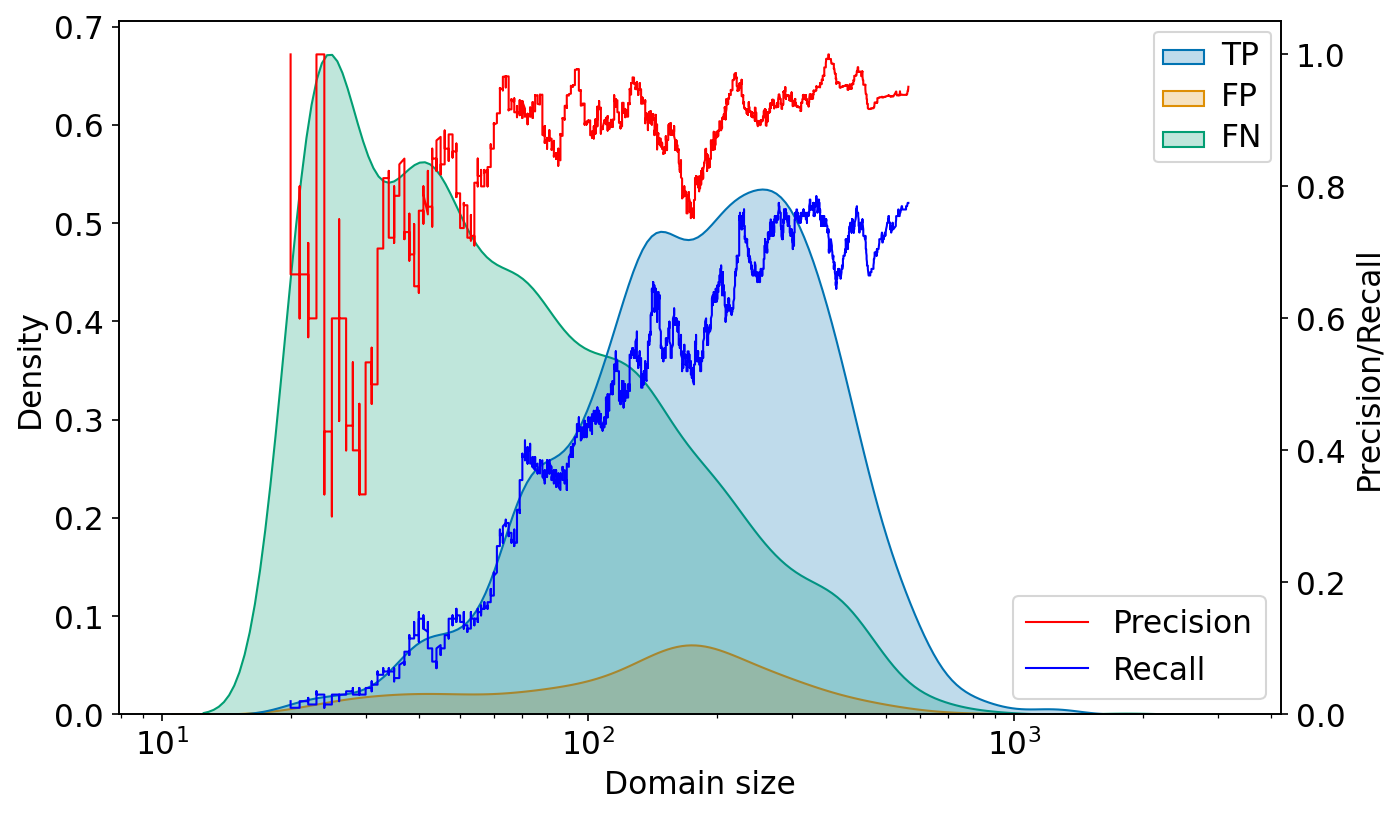

In [46]:
PlotDistributionOfLablesForAColumns(MM_preds_vsPFn, "size","Domain size",log_scale=10, legen2loc=("lower right"))

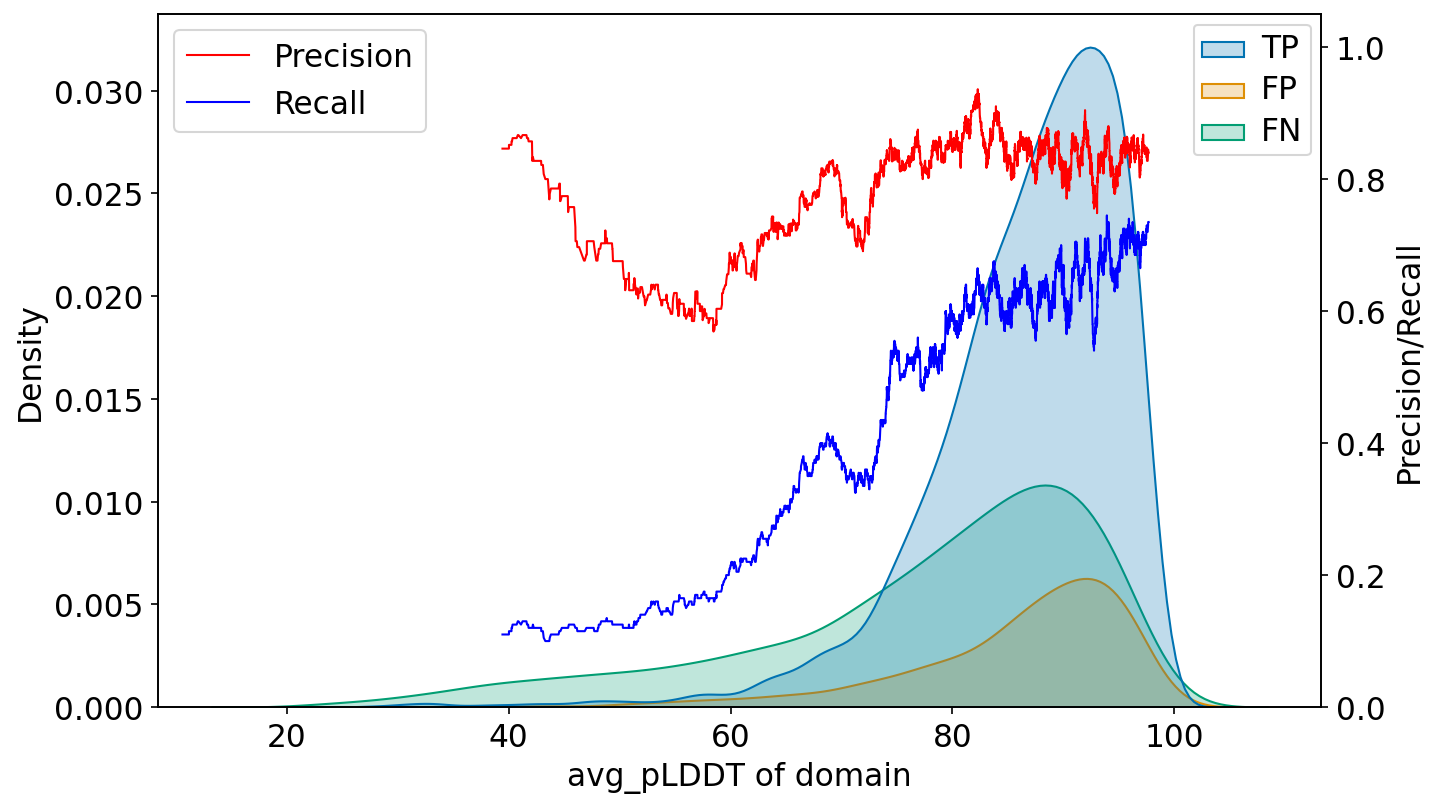

In [47]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

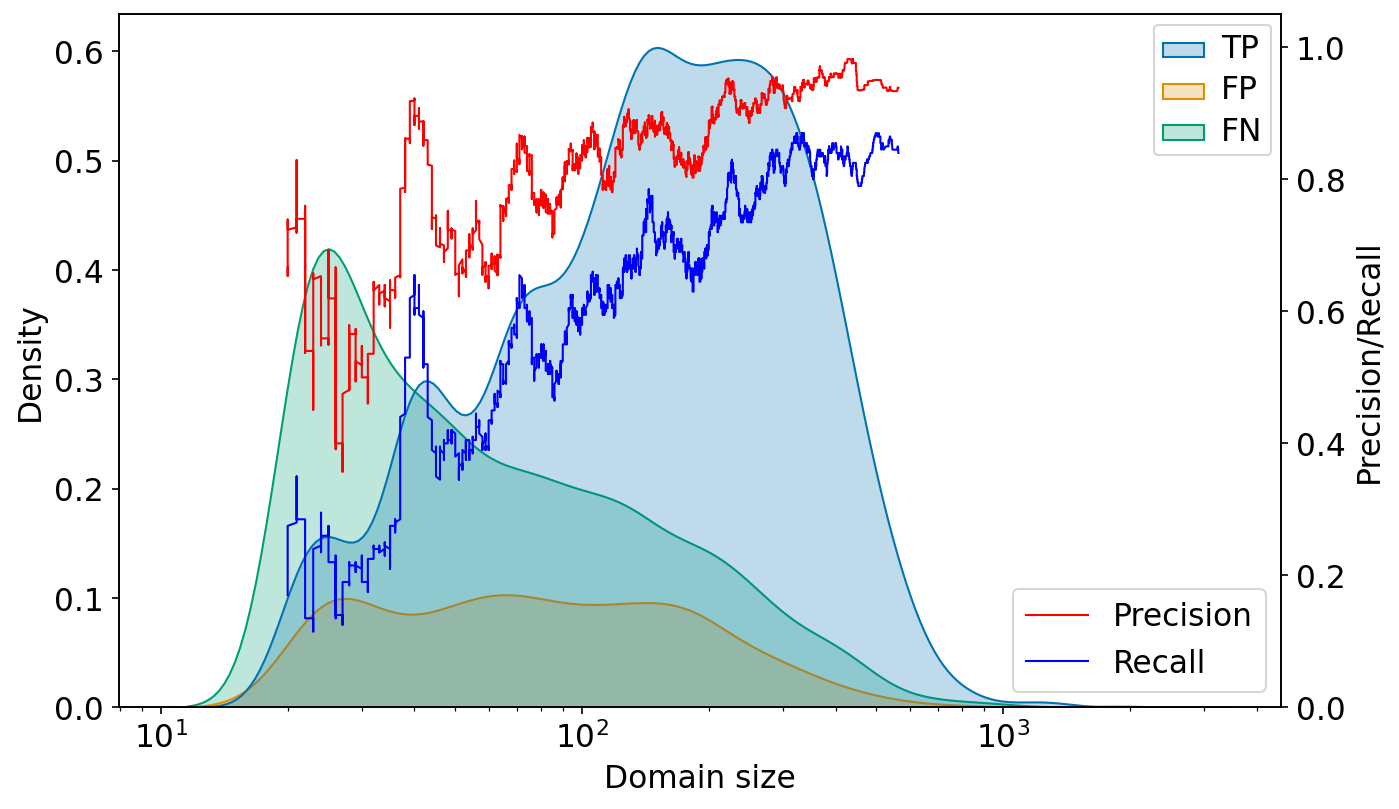

In [48]:
PlotDistributionOfLablesForAColumns(HMMER_preds_vsPFn, "size","Domain size",log_scale=10, legen2loc=("lower right"))

The following plots are for showing the distribution of query characteristics according to the label

In [88]:
correlation, p_value = spearmanr(pfn["size"], pfn["meanlddt"])
print(correlation)
print(p_value)

0.07893141506005232
1.1587525976796071e-14


## FS_cut, bits/alnlen

In [69]:
FS_preds_vsPFn = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_fscut_bits__alnlen.tsv", clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits_alnlen(x, 0.86)))

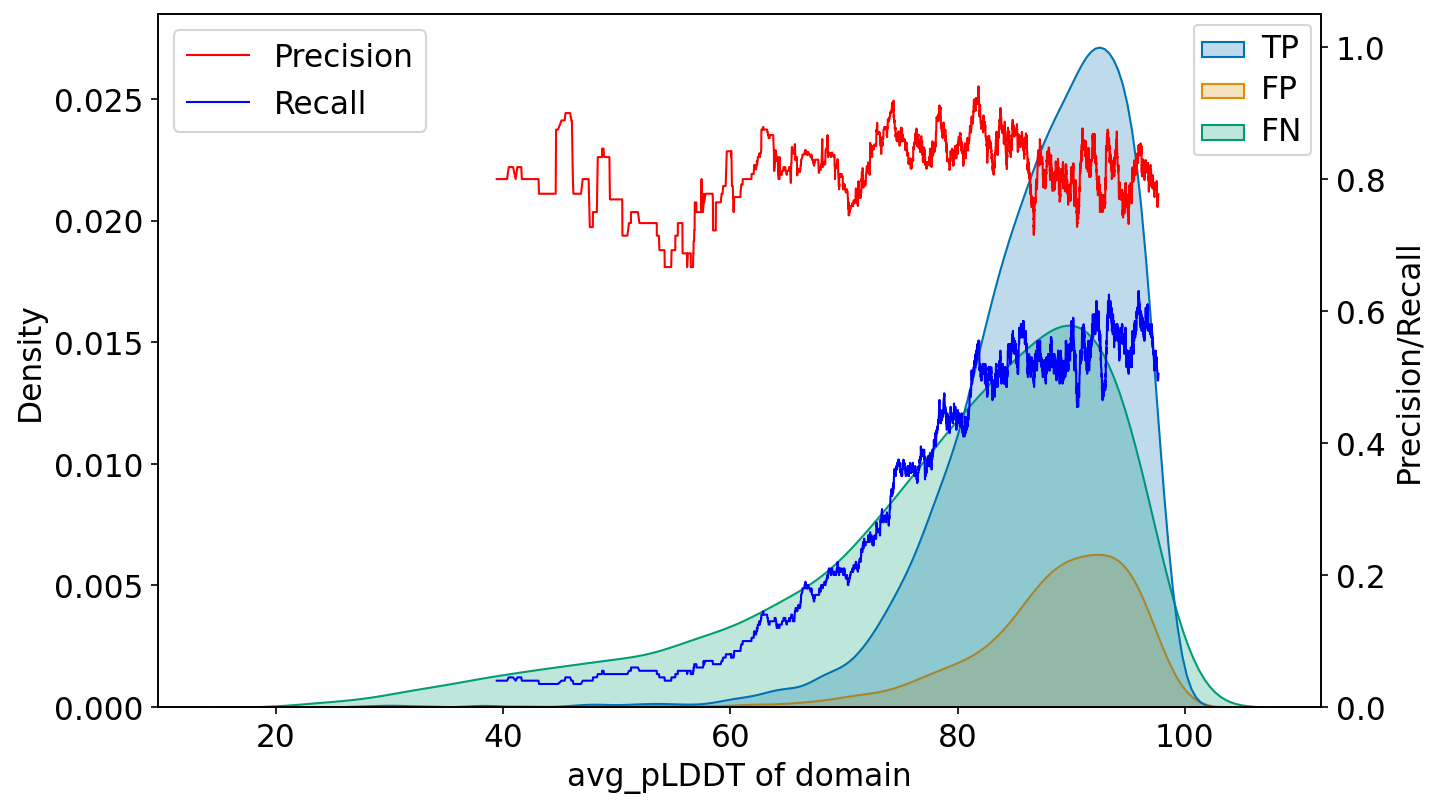

In [70]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

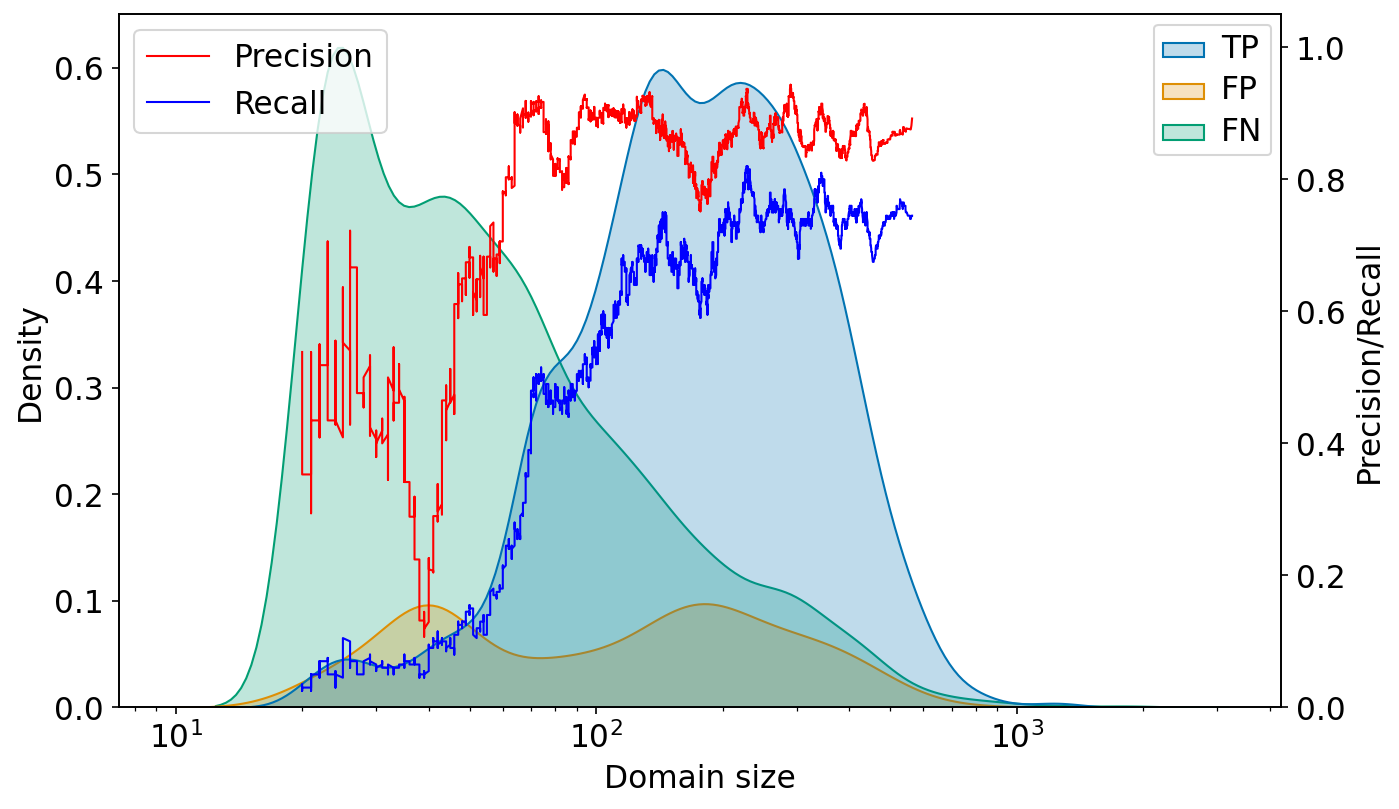

In [51]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn,"size","Domain size", log_scale=10)

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-400.0, 2000.0)

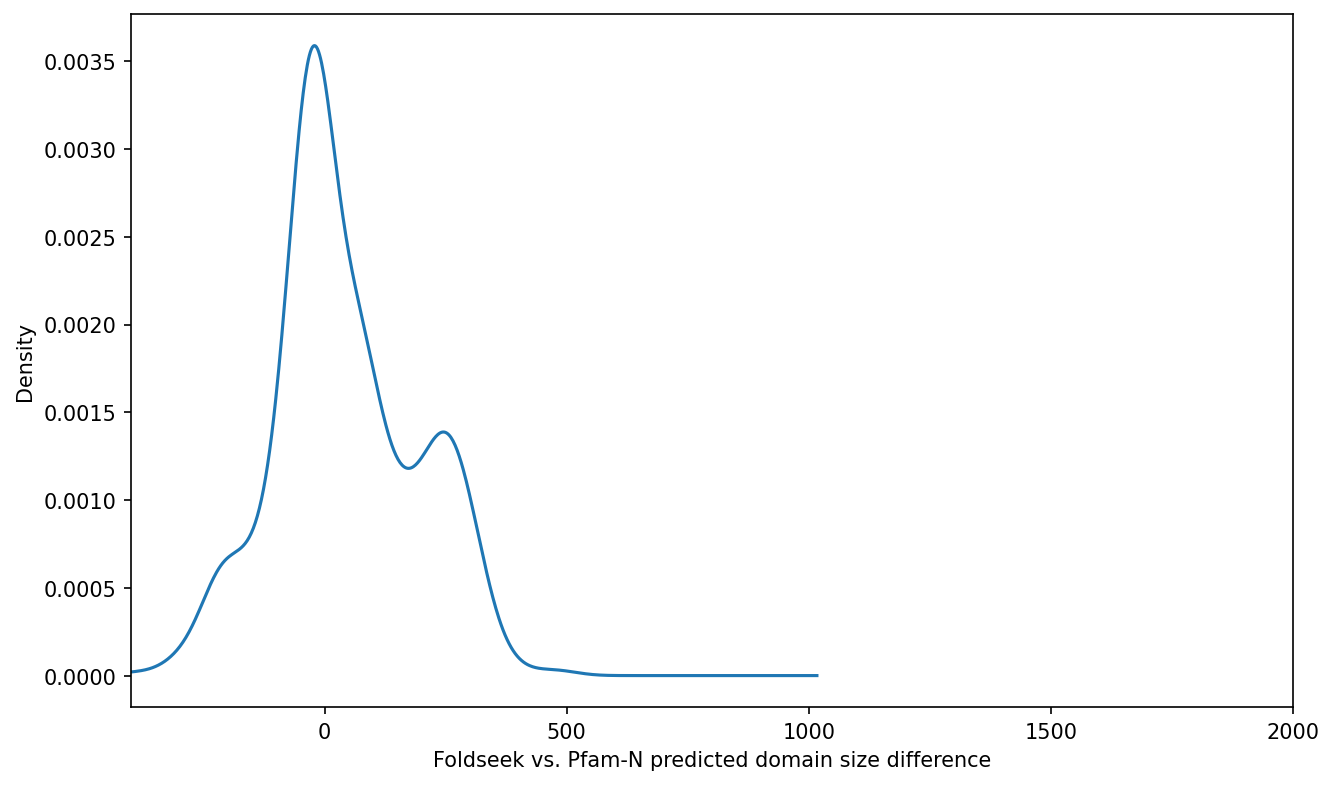

In [52]:
FPs_PFn = FS_preds_vsPFn[FS_preds_vsPFn["labelcol_str"]=="FP"]
FPs_PFn = FPs_PFn[(FPs_PFn["qend"] - FPs_PFn["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PFn["qend"] - FPs_PFn["qstart"]) - (FPs_PFn["pfend"] - FPs_PFn["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam-N predicted domain size difference")
plt.xlim((-400, 2000))

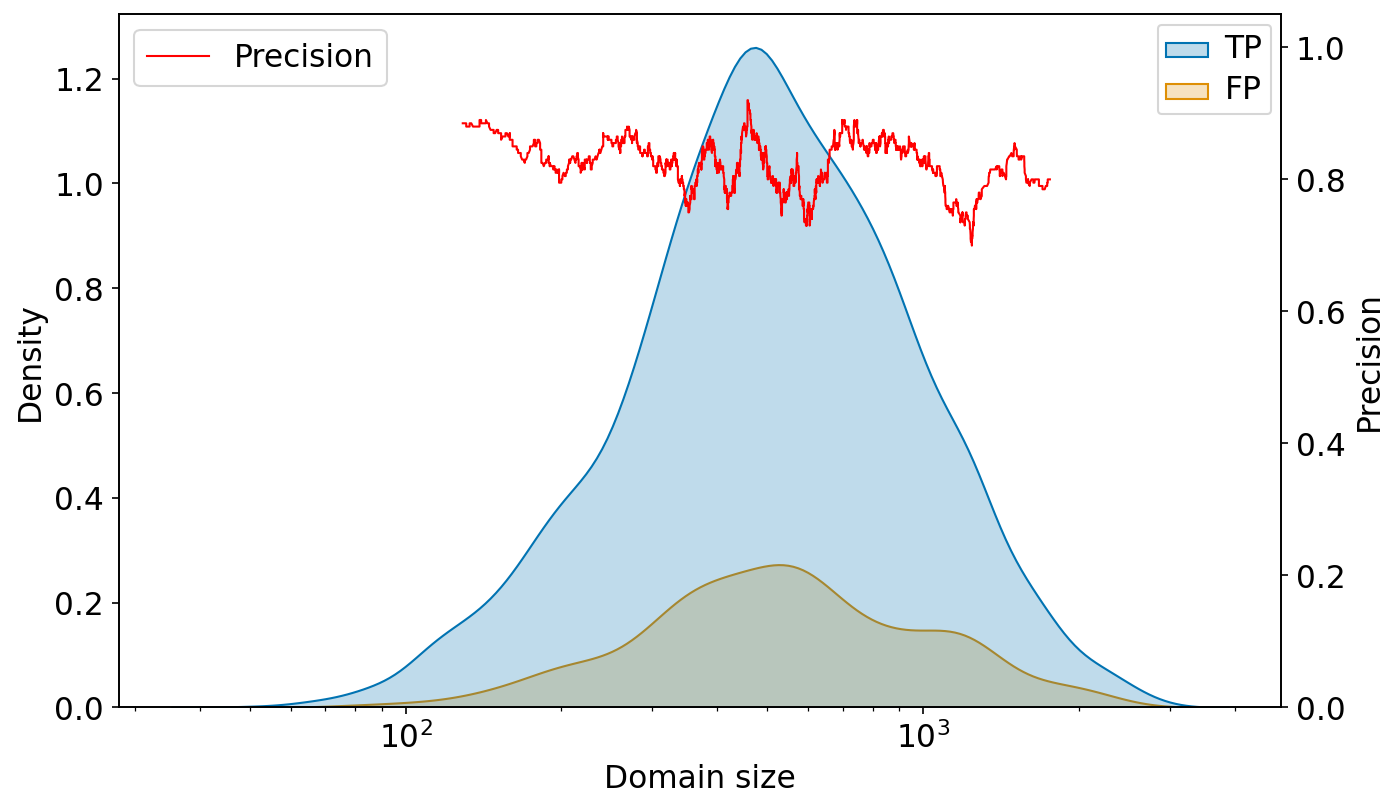

In [53]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn[FS_preds_vsPFn['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)

## PDB_cut, bits/alnlen

In [54]:
FS_preds_vsPFn = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_pdbcut_bits__alnlen.tsv", clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits_alnlen(x, 0.86)))

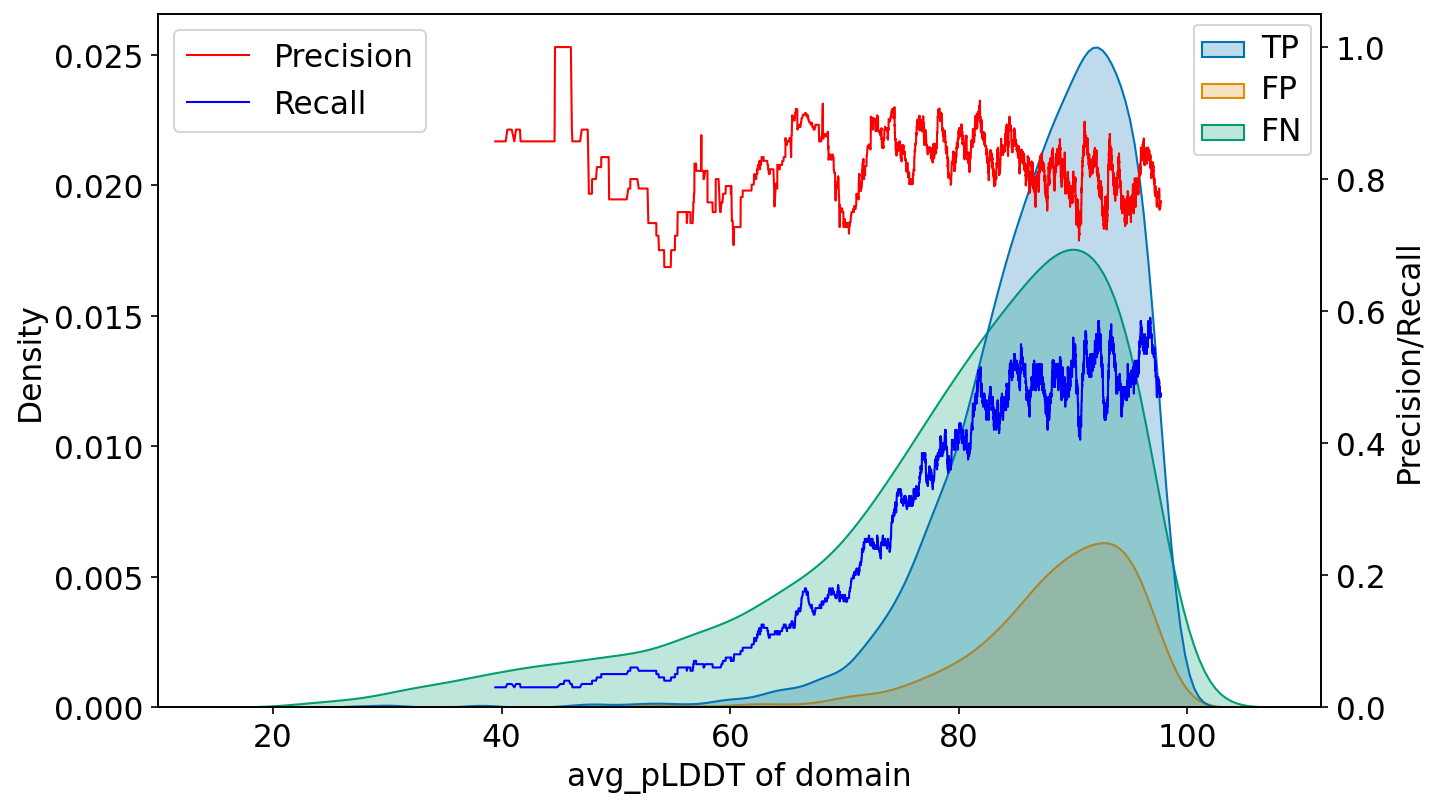

In [55]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

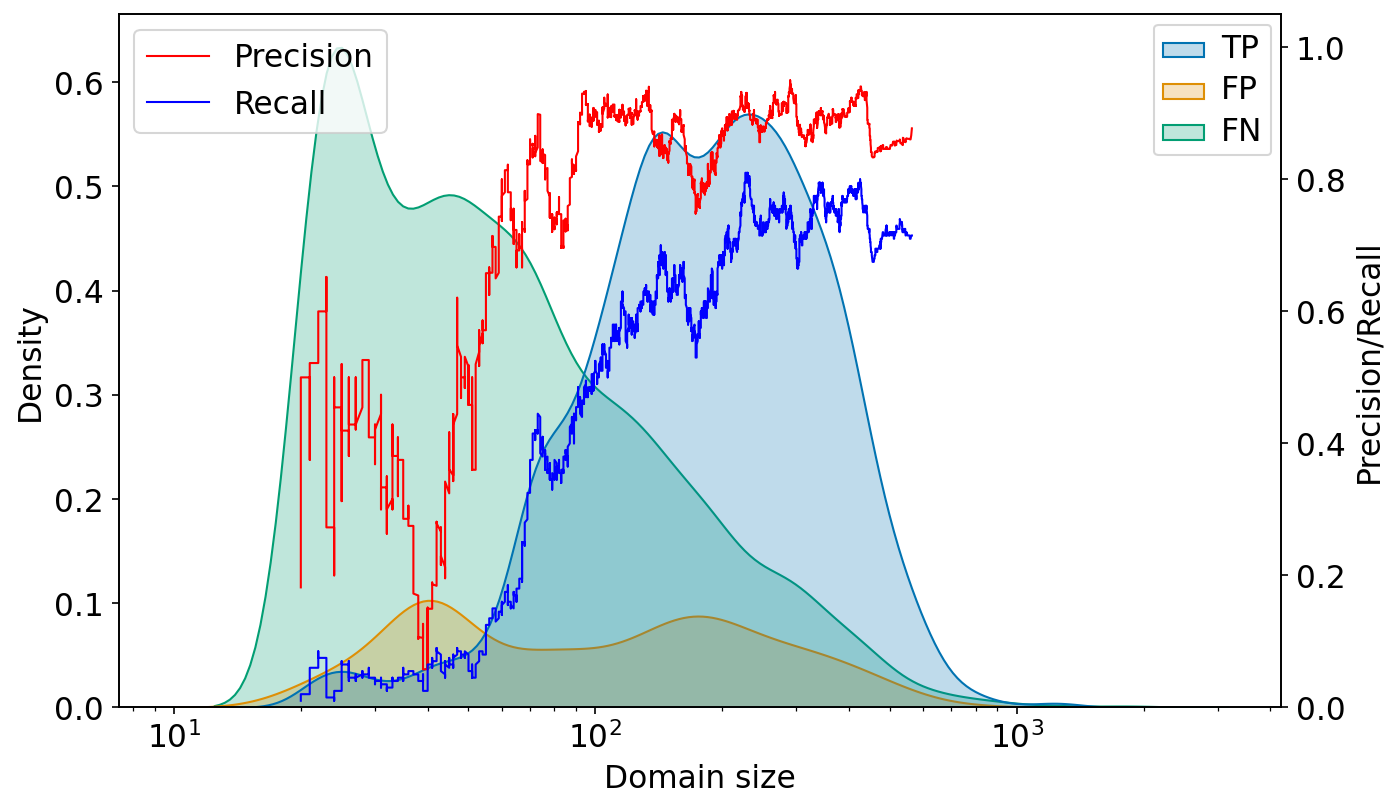

In [56]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn,"size","Domain size", log_scale=10)

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-400.0, 2000.0)

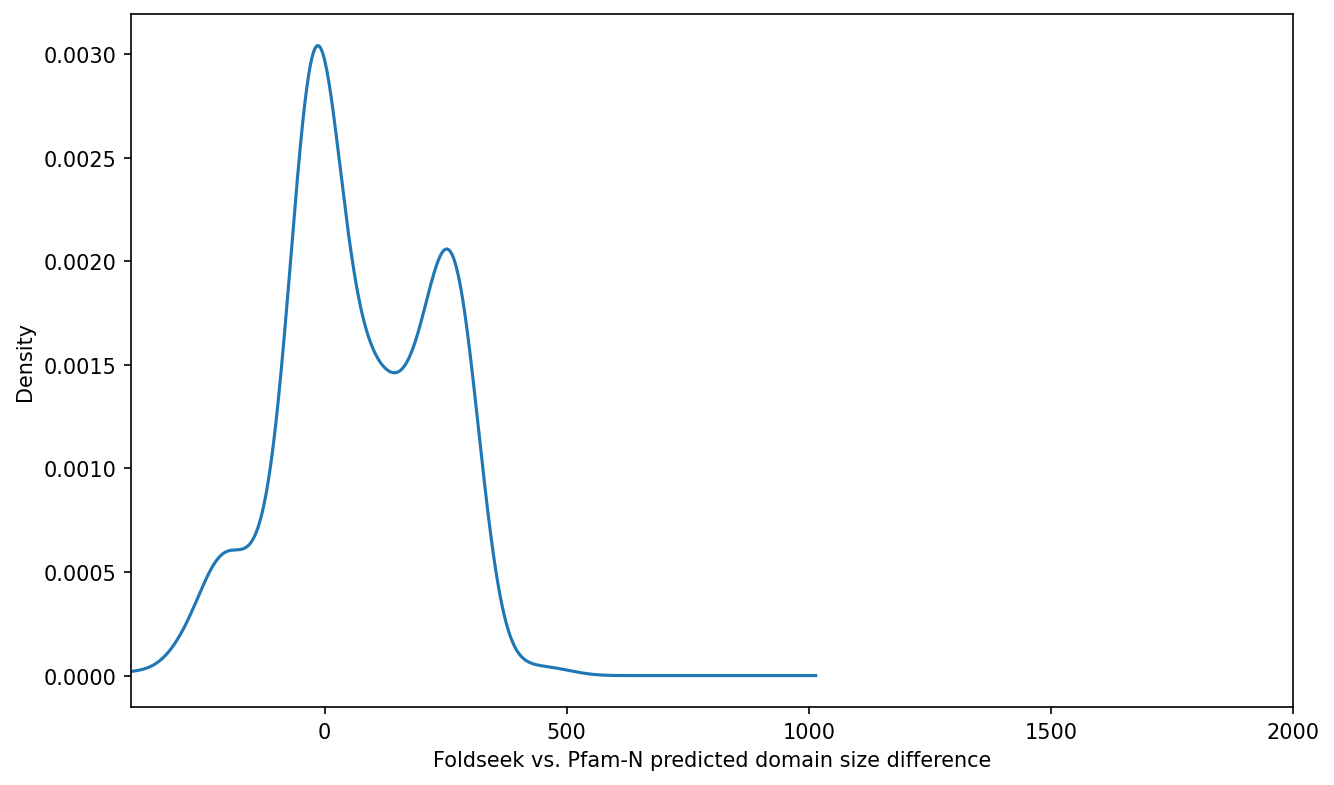

In [57]:
FPs_PFn = FS_preds_vsPFn[FS_preds_vsPFn["labelcol_str"]=="FP"]
FPs_PFn = FPs_PFn[(FPs_PFn["qend"] - FPs_PFn["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PFn["qend"] - FPs_PFn["qstart"]) - (FPs_PFn["pfend"] - FPs_PFn["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam-N predicted domain size difference")
plt.xlim((-400, 2000))

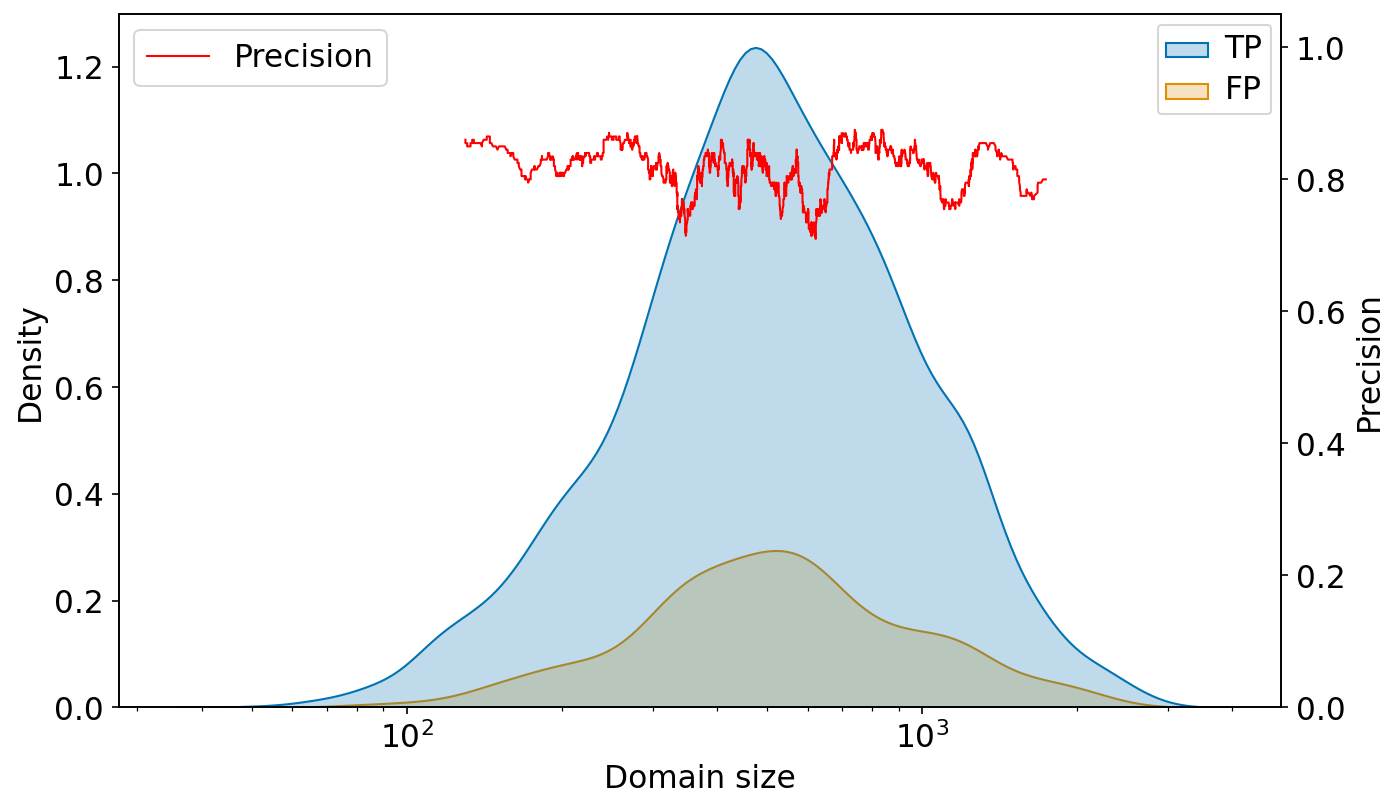

In [58]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn[FS_preds_vsPFn['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)

## FS_cut, bits

In [59]:
FS_preds_vsPFn = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_fscut.tsv", clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits(x, 152)))

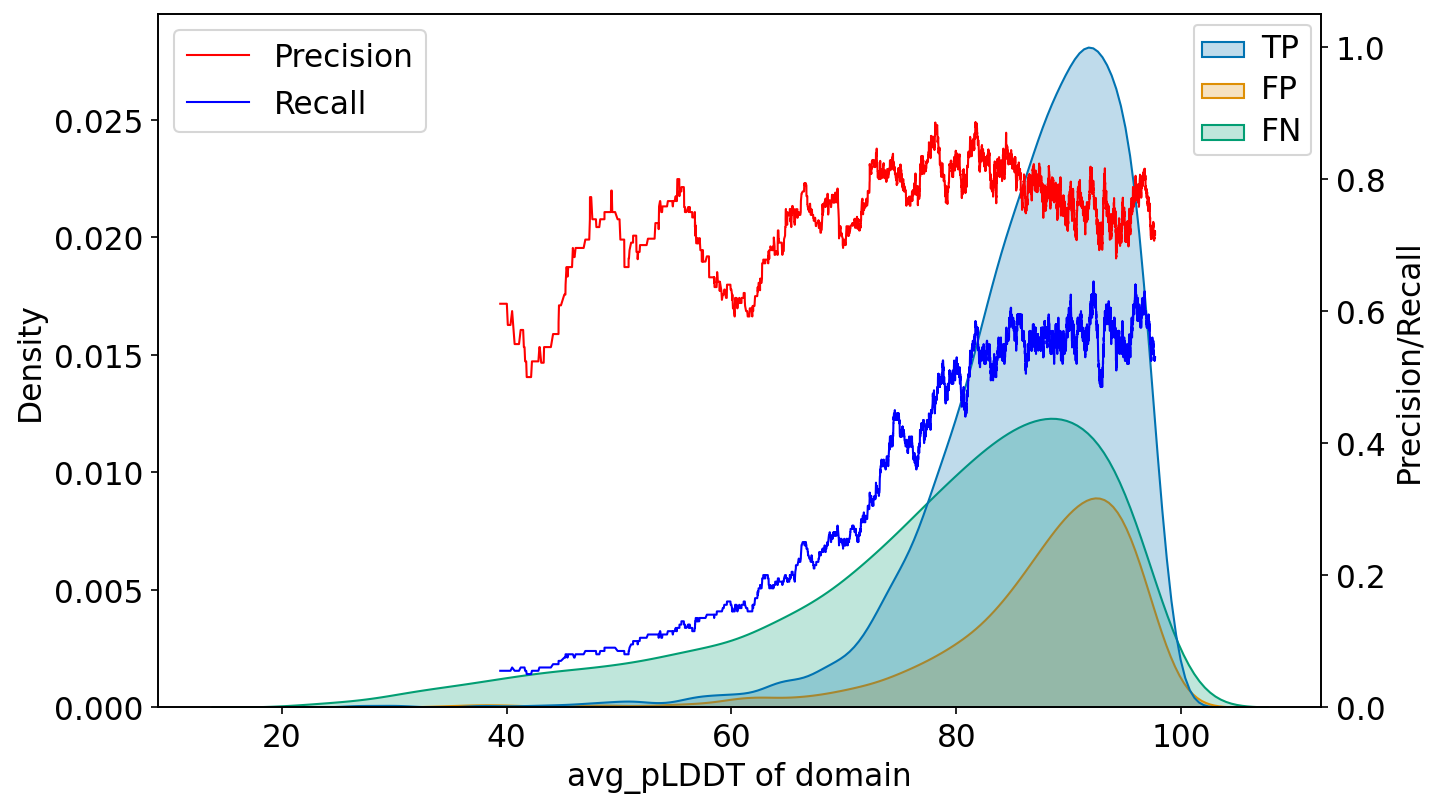

In [60]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

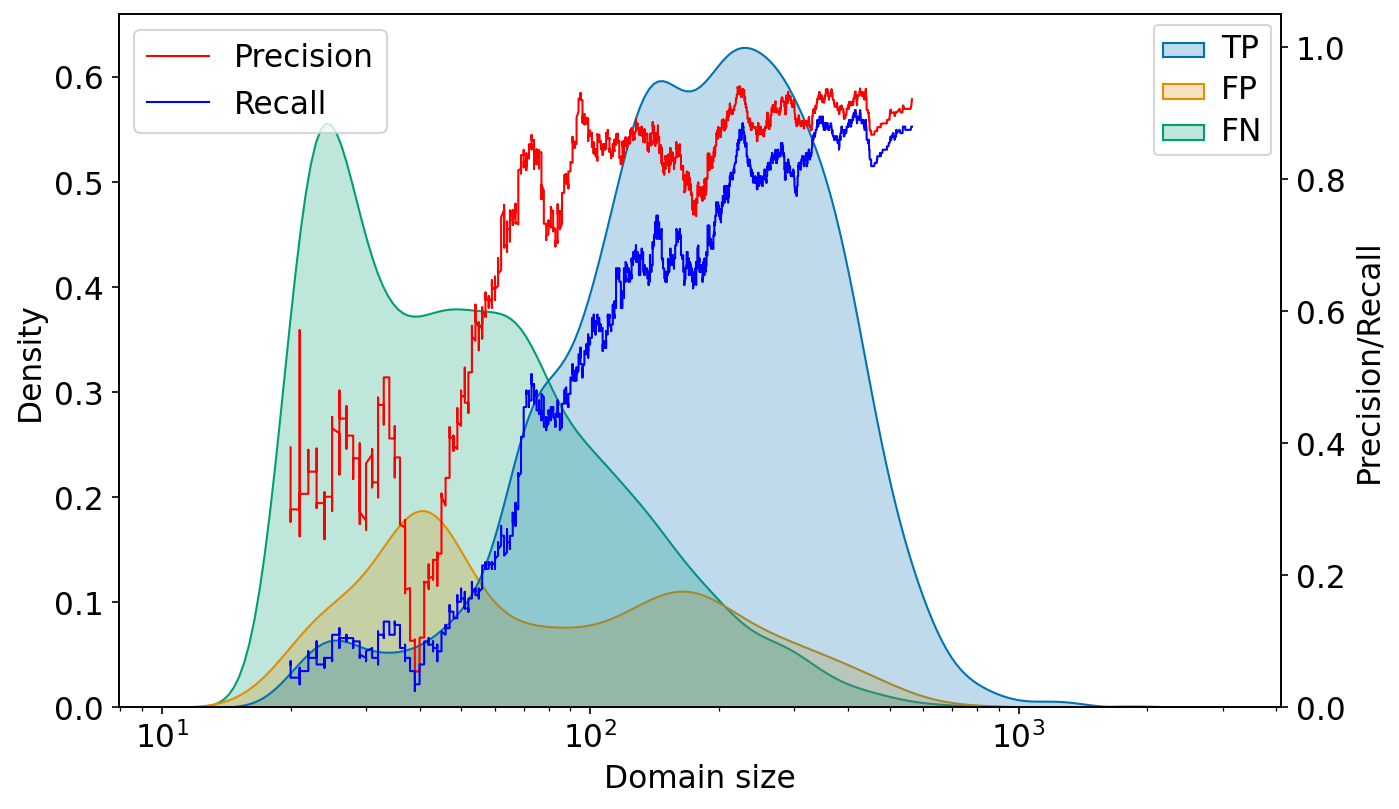

In [61]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn,"size","Domain size", log_scale=10)

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-400.0, 2000.0)

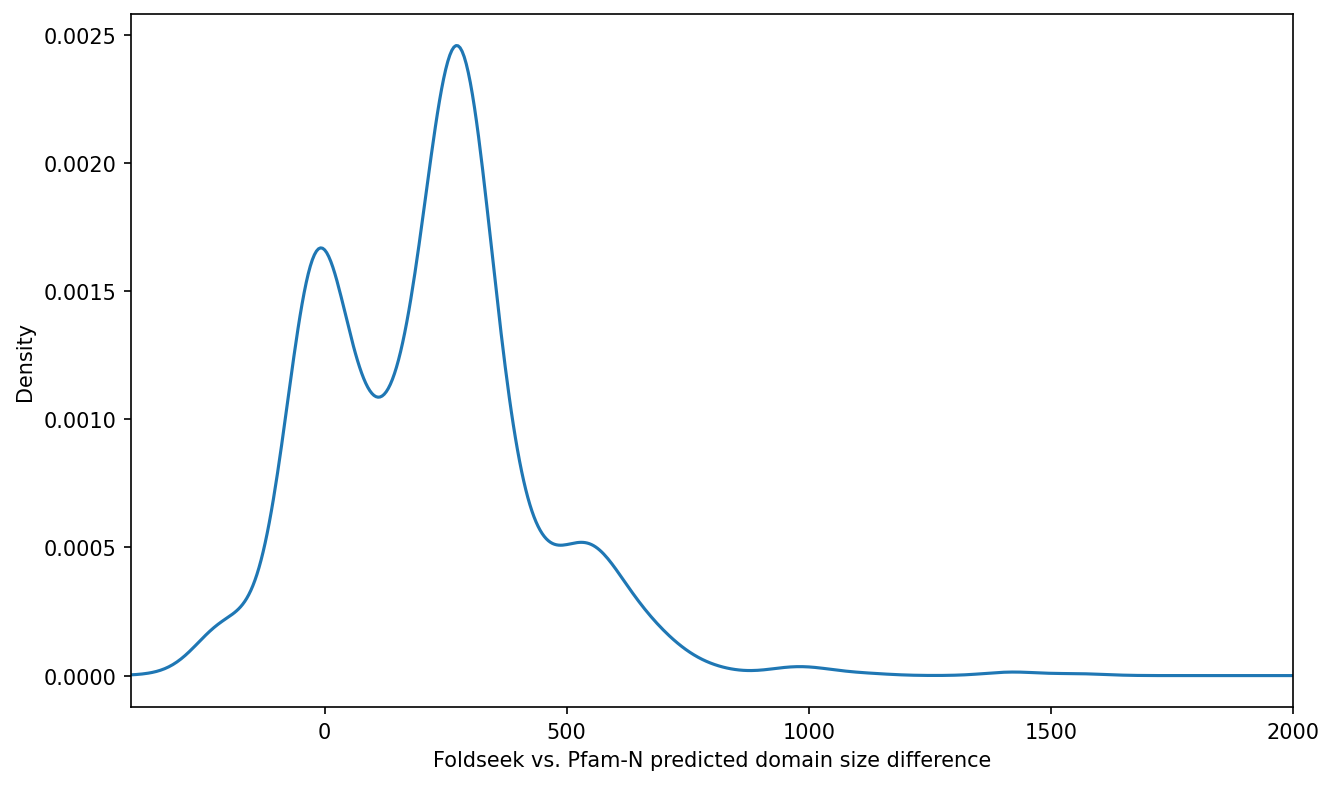

In [62]:
FPs_PFn = FS_preds_vsPFn[FS_preds_vsPFn["labelcol_str"]=="FP"]
FPs_PFn = FPs_PFn[(FPs_PFn["qend"] - FPs_PFn["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PFn["qend"] - FPs_PFn["qstart"]) - (FPs_PFn["pfend"] - FPs_PFn["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam-N predicted domain size difference")
plt.xlim((-400, 2000))

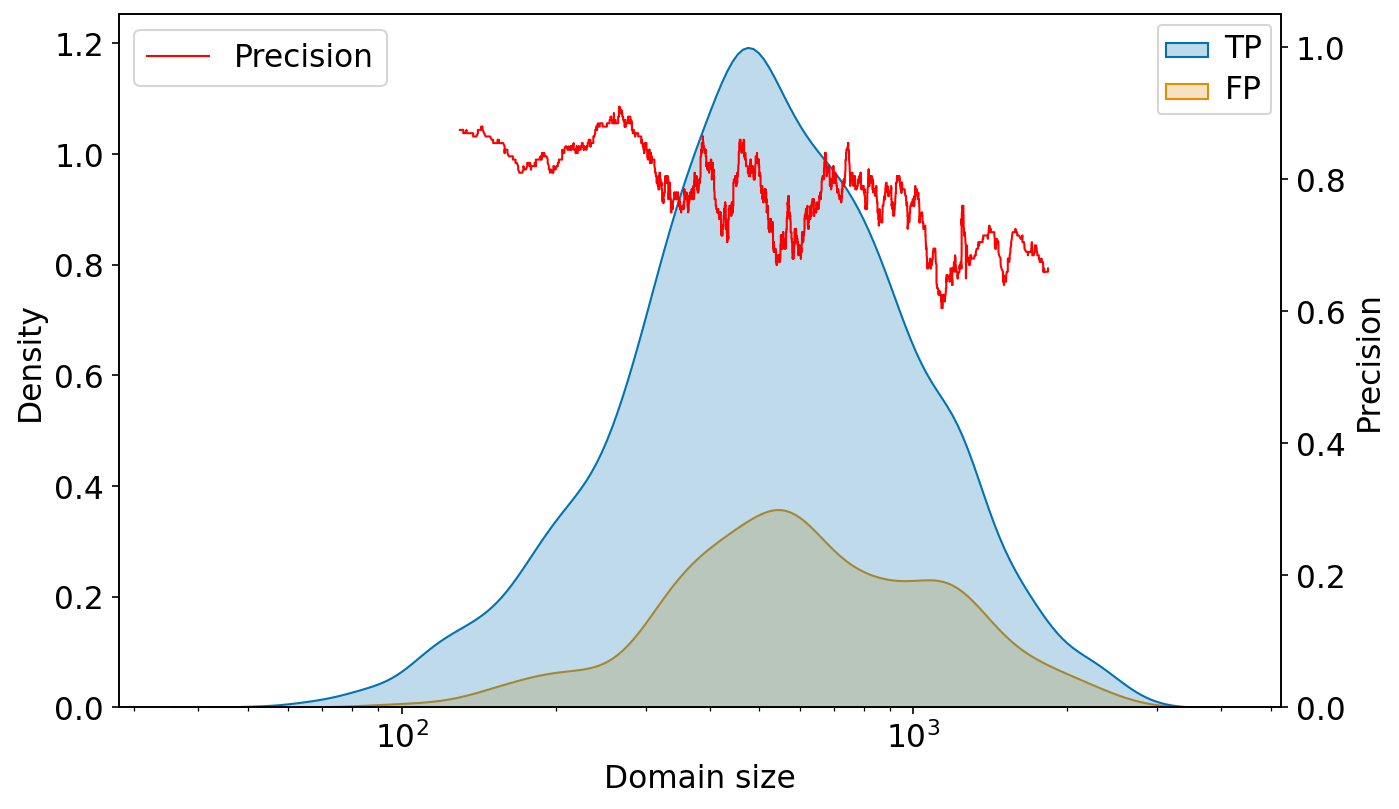

In [63]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn[FS_preds_vsPFn['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)

## PDB_cut, bits

In [64]:
FS_preds_vsPFn = OneHotEncodingLabel(Labeler("../greedy_hits/aln_Tb_pf_pdbcut.tsv", clanassociation, pfn, instance_database = True, filt=lambda x: filter_bits(x, 152)))

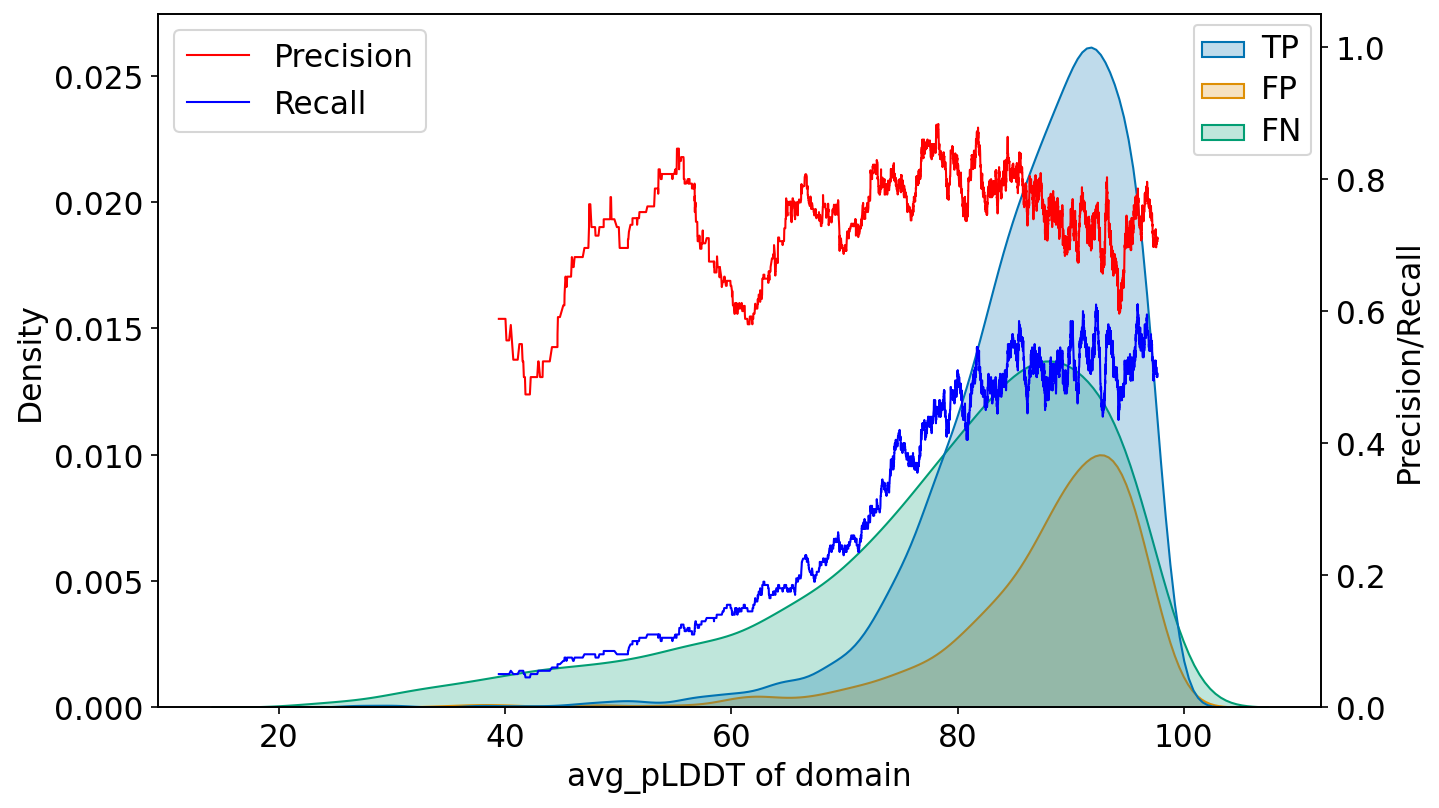

In [65]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn, "meanlddt","avg_pLDDT of domain")

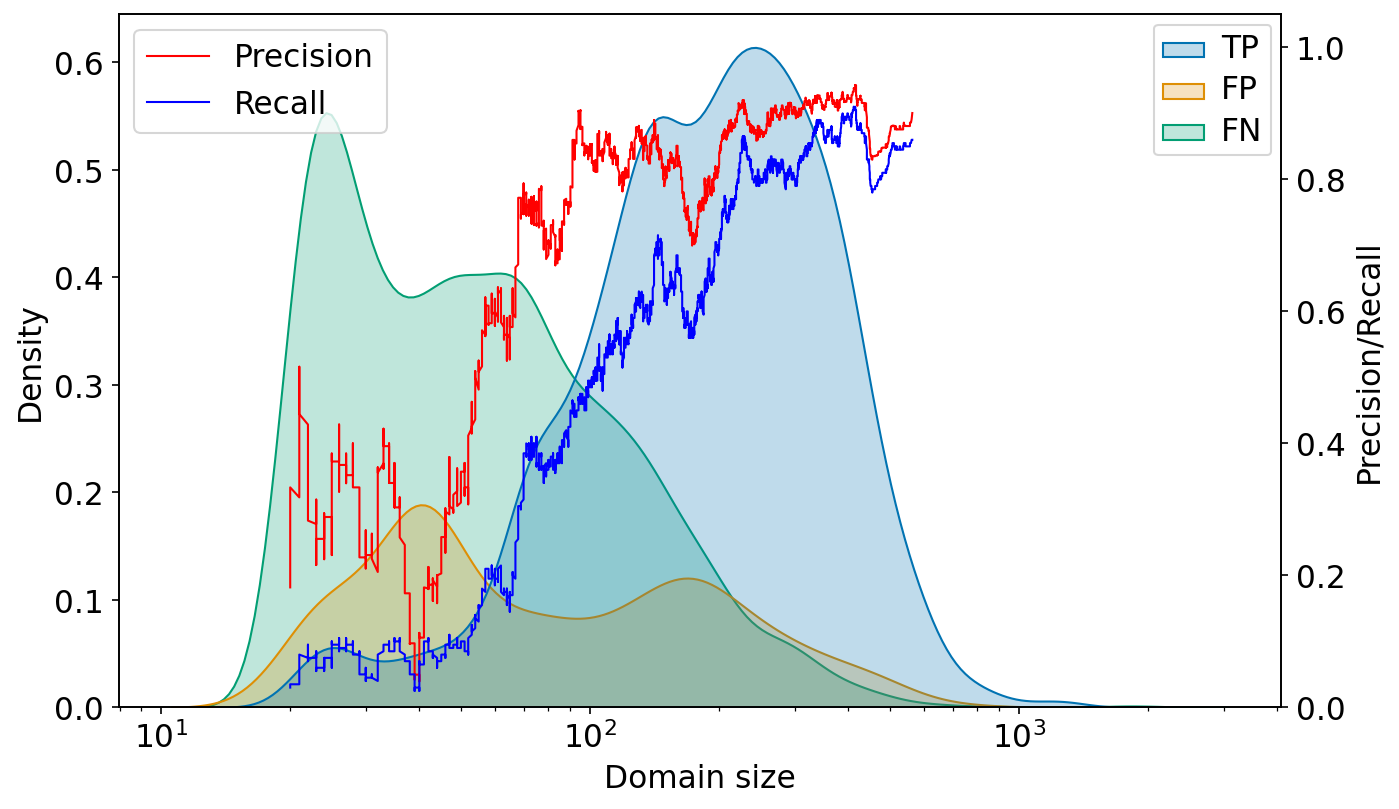

In [66]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn,"size","Domain size", log_scale=10)

Let's see the difference in the size of domains predicted by Foldseek and those predicted by Pfam v35.

(-400.0, 2000.0)

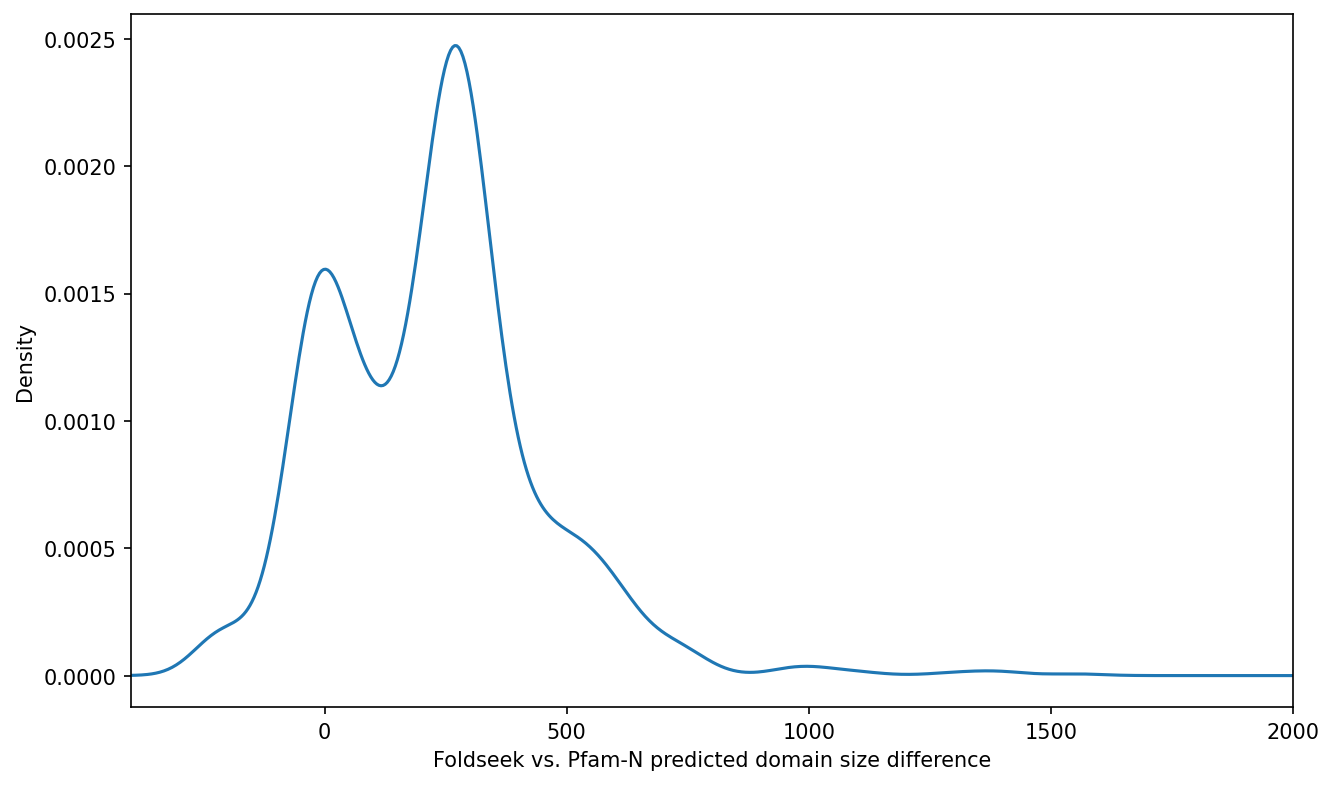

In [67]:
FPs_PFn = FS_preds_vsPFn[FS_preds_vsPFn["labelcol_str"]=="FP"]
FPs_PFn = FPs_PFn[(FPs_PFn["qend"] - FPs_PFn["qstart"]+1)>=100]
plt.figure(figsize=(10, 6), dpi=150)
((FPs_PFn["qend"] - FPs_PFn["qstart"]) - (FPs_PFn["pfend"] - FPs_PFn["pfstart"])).plot.kde()
plt.xlabel("Foldseek vs. Pfam-N predicted domain size difference")
plt.xlim((-400, 2000))

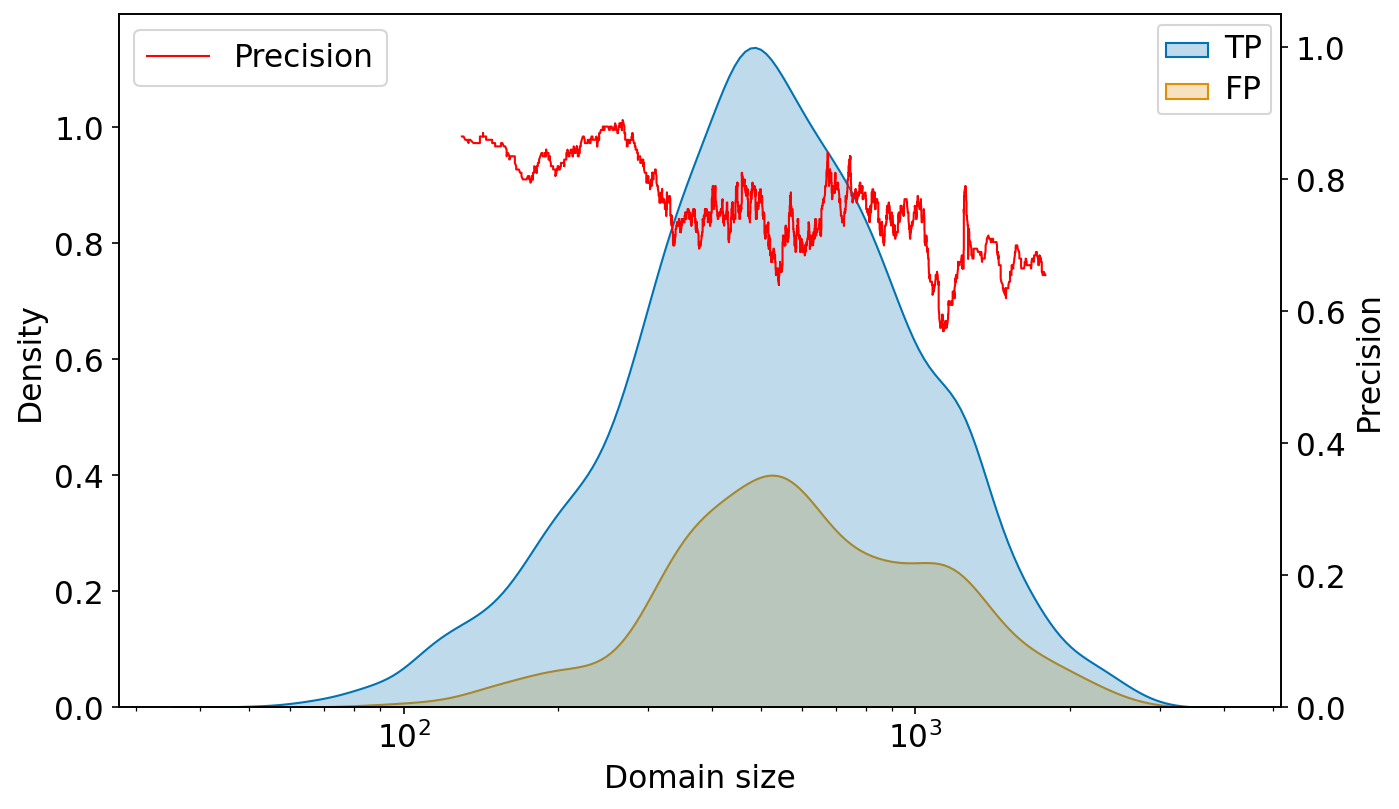

In [68]:
PlotDistributionOfLablesForAColumns(FS_preds_vsPFn[FS_preds_vsPFn['labelcol_str']!="FN"], "qlen", "Domain size", log_scale=10)